<a href="https://colab.research.google.com/github/lrrong2020/A/blob/main/FYP_Pro_T4_overfit_solve_04_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import auth
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "MyDrive"
!google-drive-ocamlfuse "/content/gdrive/MyDrive"

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=I7oiTqaMn8WIgf7YO86CfKKolWM21w%2FzqzlnyyMaWcQ'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/usr/bin/open: 882: www-browser: not found
/usr/bin/open: 882: links2: not found
/usr/bin/open: 882: elinks: not found
/usr/bin/open: 882: links: not found
/usr/bin/open: 882: lynx: not found
/usr/bin/open: 882: w3m: not found
xdg-open: no method available for opening

Prep

In [5]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/data.zip /home





In [6]:
%cd /home
!unzip -nq /home/data.zip "train/*"



/home


In [7]:

!rm /home/data.zip

#GitHub

In [1]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.
import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader #For working with data.
from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

#manual seed for reproductivity and potential performance improvement
torch.manual_seed(3407)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [3]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/allLabels.csv /home

In [4]:

path = "/home/"

#label csv
all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split
# subset for hyperparameters tuning

part = 0.80
train_df, drop_df = train_test_split(all_df, test_size=part, random_state=42)
test_sample_size = round(7000 * (1 - part) )  #roughtly 1/3
train_df, test_df = train_test_split(train_df, test_size=test_sample_size, random_state=42)

# Assuming train_df is your original training DataFrame
# test_sample_size = 7000 # roughtly 1/3
# train_df, test_df = train_test_split(all_df, test_size=test_sample_size, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 5062
No.of.testing_samples: 1400
No.of.val_samples: 563


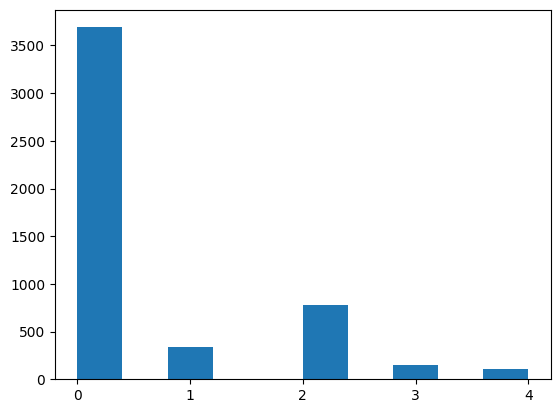

In [5]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [68]:
!nvidia-smi -r

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.


In [6]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.2743, 2.9776, 1.3030, 6.9342, 9.3741], device='cuda:0')


In [45]:
#For getting a random image from our training set.
# num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
# sample_image = (f'{path}train/{train_df["image"][num]}.jpeg')#Image file.
# sample_image = Image.open(sample_image)
# plt.imshow(sample_image)
# plt.axis('off')
# plt.title(f'Class: {train_df["level"][num]}') #Class of the random image.
# plt.show()

In [7]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.


In [8]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_set = dataset(train_df,f'{path}train',image_transform=image_transform)
test_set = dataset(test_df,f'{path}train',image_transform=image_transform)
valid_set = dataset(valid_df,f'{path}train',image_transform=image_transform)

In [9]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4)

In [10]:
from torchvision.models import inception_v3,Inception_V3_Weights

model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
)

In [53]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

In [11]:
model = model.to(device) #Moves the model to the device.

In [18]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.


        output, aux_output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        #for memory
        torch.cuda.empty_cache()

        # Print some information every 100 batches
        if batch % 70 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, '/content/gdrive/MyDrive/Kaggle/unzip/DR_InceptionV3.pt')
    return avg_loss, accuracy

In [13]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [14]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'g', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [15]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    # scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)


        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')

            # Save to CSV
            df.to_csv('training_validation_metrics.csv', index=False)
            break

        # Step the learning rate scheduler
        # scheduler.step()
        scheduler.step(valid_loss)

        df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)

    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses


Epoch 1/50
-------------------------------
Epoch: 0, Learning Rate: 0.005000 
Batch 0/317 processed, running loss: 1.011672, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 81.363784, correct predictions: 539, total: 1136
Batch 140/317 processed, running loss: 162.148394, correct predictions: 1149, total: 2256
Batch 210/317 processed, running loss: 241.357409, correct predictions: 1845, total: 3376
Batch 280/317 processed, running loss: 318.712862, correct predictions: 2376, total: 4496

Training Loss per batch = 1.139828	Accuracy on Training set = 51.876729% [2626/5062]

Validation Loss per batch = 1.118693	Accuracy on Validation set = 29.484902% [166/563]
Train Loss: 1.1398, Train Accuracy: 51.8767
Valid Loss: 1.1187, Valid Accuracy: 29.4849


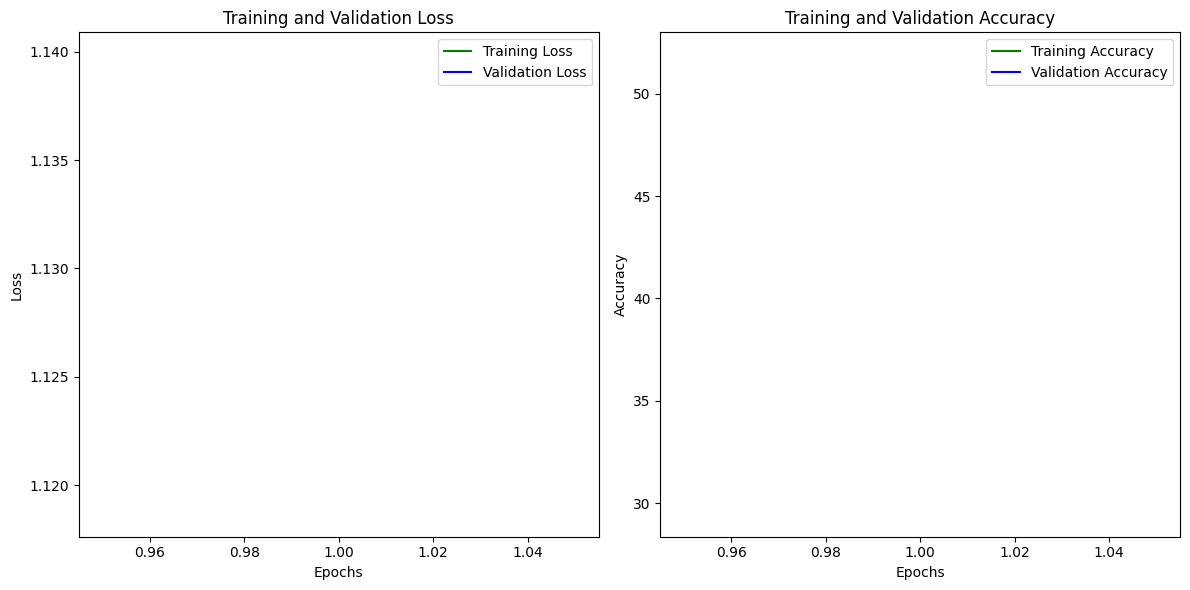


Epoch 2/50
-------------------------------
Epoch: 1, Learning Rate: 0.005000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.298125, correct predictions: 4, total: 16
Batch 70/317 processed, running loss: 72.750300, correct predictions: 605, total: 1136
Batch 140/317 processed, running loss: 147.658745, correct predictions: 1266, total: 2256
Batch 210/317 processed, running loss: 219.485387, correct predictions: 1830, total: 3376
Batch 280/317 processed, running loss: 292.084680, correct predictions: 2392, total: 4496

Training Loss per batch = 1.041747	Accuracy on Training set = 53.338601% [2700/5062]

Validation Loss per batch = 1.163354	Accuracy on Validation set = 46.891652% [264/563]
Train Loss: 1.0417, Train Accuracy: 53.3386
Valid Loss: 1.1634, Valid Accuracy: 46.8917


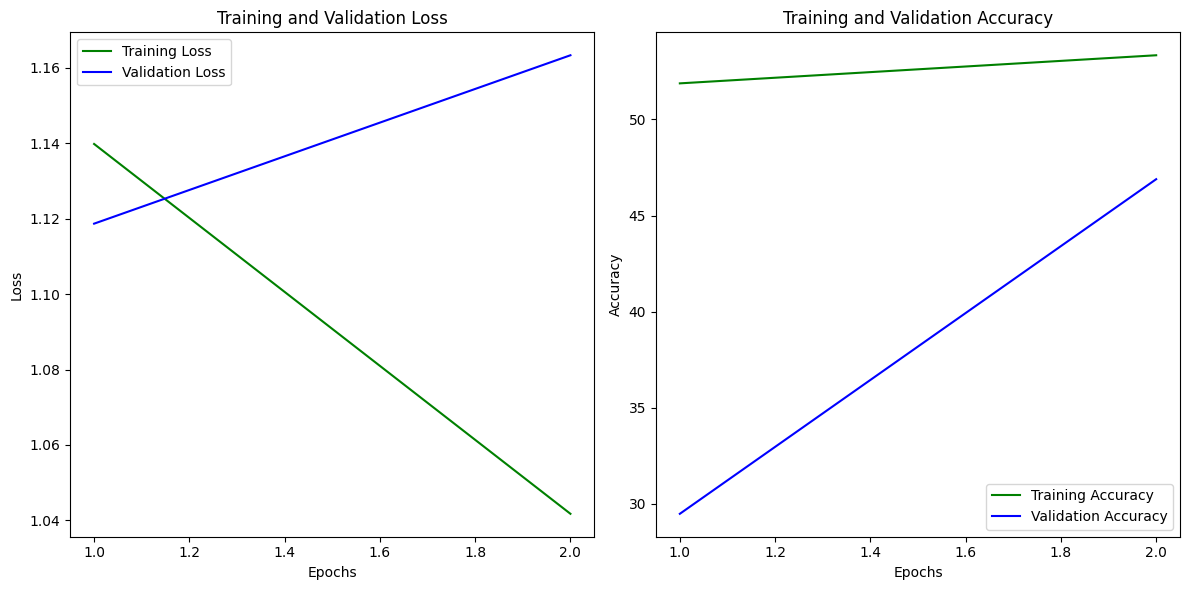


Epoch 3/50
-------------------------------
Epoch: 2, Learning Rate: 0.005000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.811003, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 64.717195, correct predictions: 706, total: 1136
Batch 140/317 processed, running loss: 128.656081, correct predictions: 1372, total: 2256
Batch 210/317 processed, running loss: 194.810735, correct predictions: 2007, total: 3376
Batch 280/317 processed, running loss: 265.762913, correct predictions: 2595, total: 4496

Training Loss per batch = 0.956342	Accuracy on Training set = 57.092058% [2890/5062]

Validation Loss per batch = 1.060336	Accuracy on Validation set = 53.996448% [304/563]
Train Loss: 0.9563, Train Accuracy: 57.0921
Valid Loss: 1.0603, Valid Accuracy: 53.9964


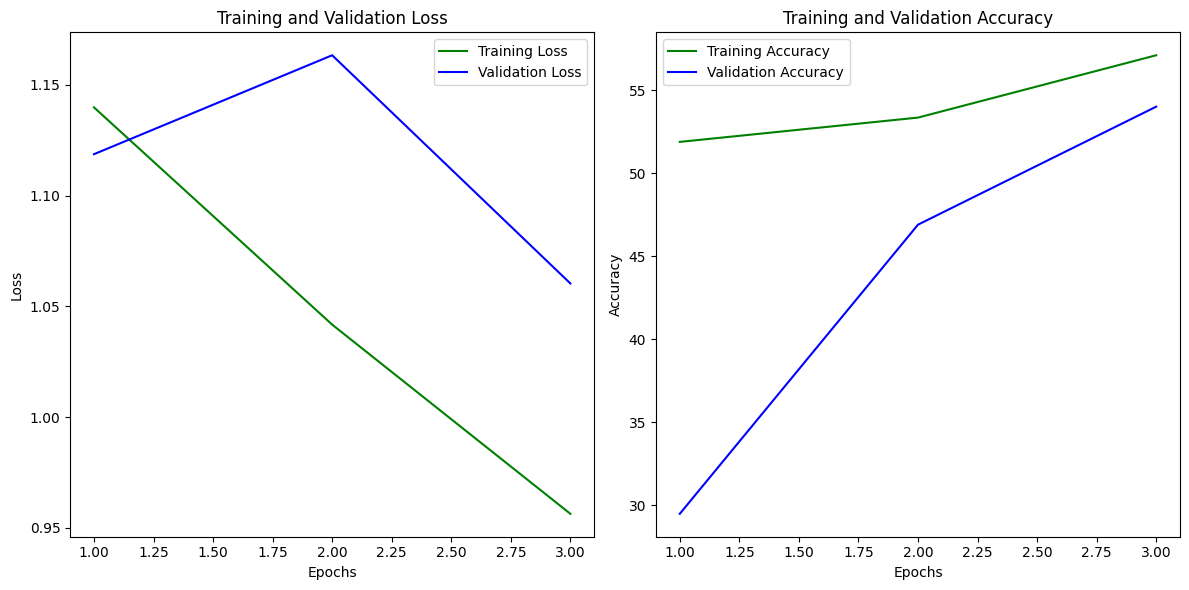


Epoch 4/50
-------------------------------
Epoch: 3, Learning Rate: 0.005000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.792080, correct predictions: 9, total: 16
Batch 70/317 processed, running loss: 53.812618, correct predictions: 705, total: 1136
Batch 140/317 processed, running loss: 109.109847, correct predictions: 1423, total: 2256
Batch 210/317 processed, running loss: 164.013208, correct predictions: 2057, total: 3376
Batch 280/317 processed, running loss: 222.223855, correct predictions: 2798, total: 4496

Training Loss per batch = 0.794569	Accuracy on Training set = 62.366653% [3157/5062]

Validation Loss per batch = 1.107033	Accuracy on Validation set = 56.127886% [316/563]
Train Loss: 0.7946, Train Accuracy: 62.3667
Valid Loss: 1.1070, Valid Accuracy: 56.1279


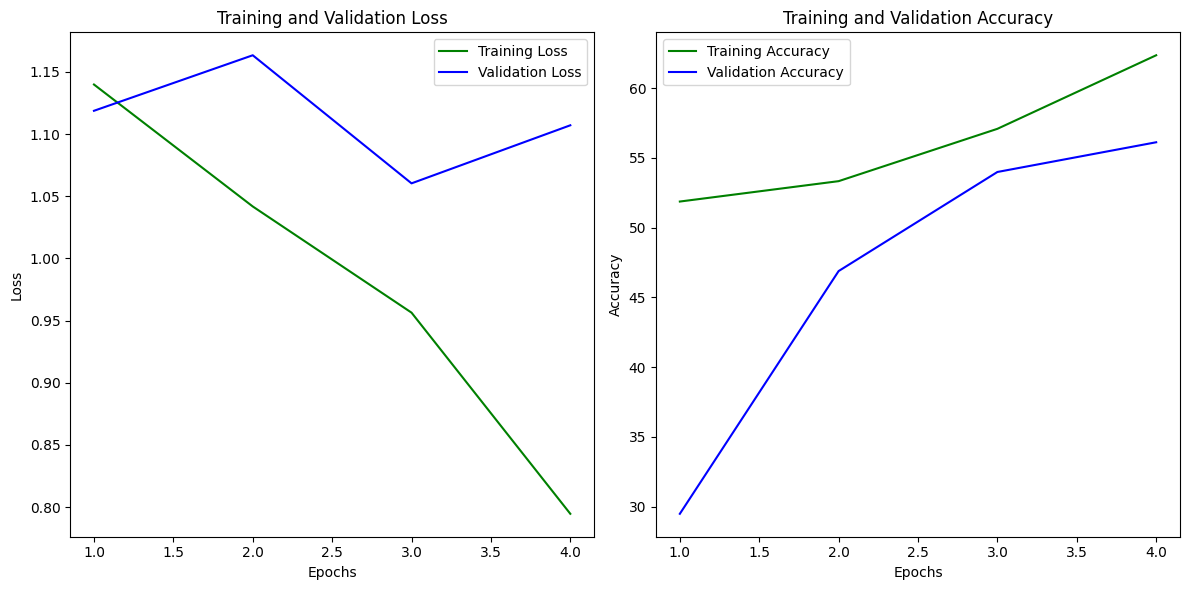


Epoch 5/50
-------------------------------
Epoch: 4, Learning Rate: 0.005000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.634845, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 45.405210, correct predictions: 800, total: 1136
Batch 140/317 processed, running loss: 95.338875, correct predictions: 1531, total: 2256
Batch 210/317 processed, running loss: 145.065468, correct predictions: 2288, total: 3376
Batch 280/317 processed, running loss: 201.304937, correct predictions: 2971, total: 4496

Training Loss per batch = 0.715290	Accuracy on Training set = 65.665745% [3324/5062]

Validation Loss per batch = 1.164794	Accuracy on Validation set = 74.245115% [418/563]
Train Loss: 0.7153, Train Accuracy: 65.6657
Valid Loss: 1.1648, Valid Accuracy: 74.2451


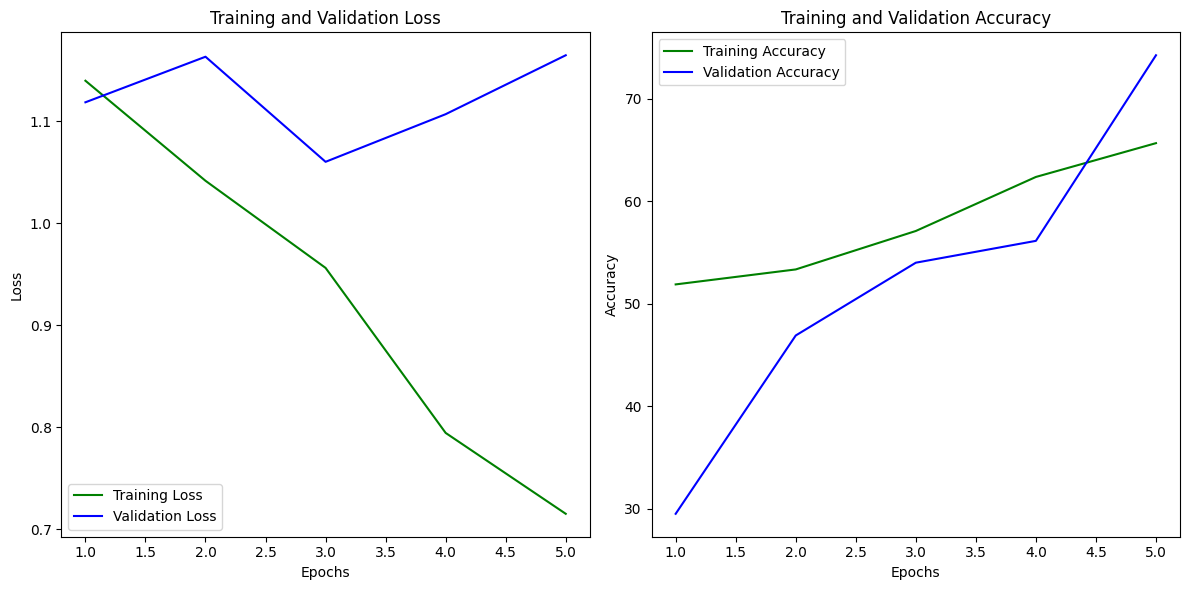


Epoch 6/50
-------------------------------
Epoch: 5, Learning Rate: 0.005000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.795440, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 42.880449, correct predictions: 794, total: 1136
Batch 140/317 processed, running loss: 81.683635, correct predictions: 1634, total: 2256
Batch 210/317 processed, running loss: 119.446542, correct predictions: 2477, total: 3376
Batch 280/317 processed, running loss: 163.219623, correct predictions: 3287, total: 4496

Training Loss per batch = 0.587061	Accuracy on Training set = 72.975109% [3694/5062]

Validation Loss per batch = 1.218154	Accuracy on Validation set = 49.023091% [276/563]
Train Loss: 0.5871, Train Accuracy: 72.9751
Valid Loss: 1.2182, Valid Accuracy: 49.0231


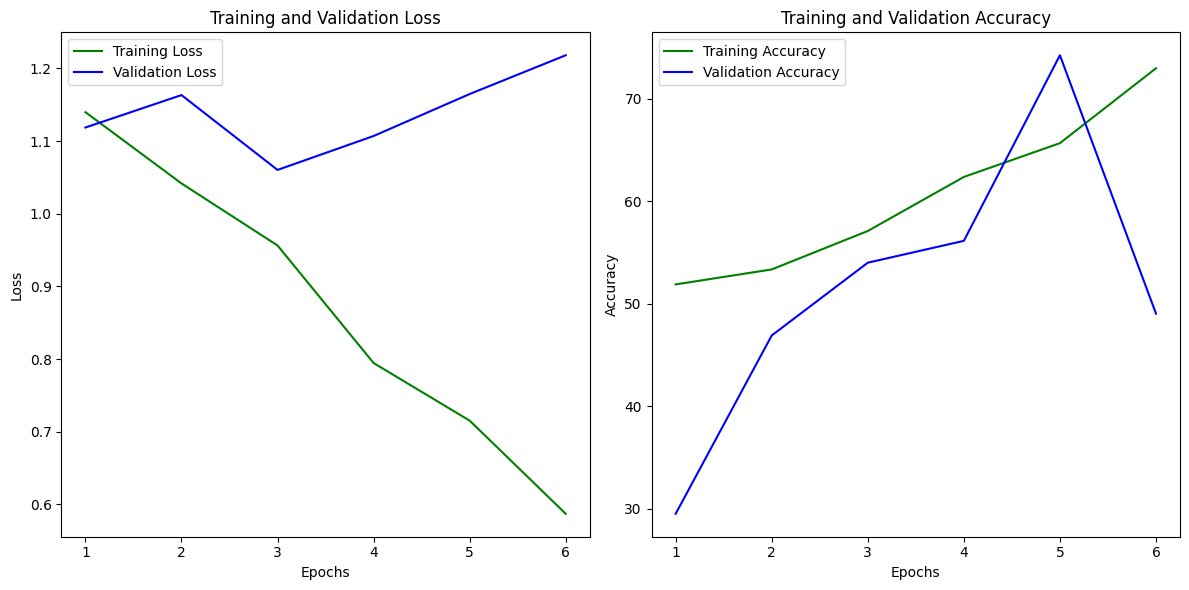


Epoch 7/50
-------------------------------
Epoch: 6, Learning Rate: 0.005000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.258265, correct predictions: 9, total: 16
Batch 70/317 processed, running loss: 29.069307, correct predictions: 901, total: 1136
Batch 140/317 processed, running loss: 62.207317, correct predictions: 1766, total: 2256
Batch 210/317 processed, running loss: 90.756166, correct predictions: 2650, total: 3376
Batch 280/317 processed, running loss: 123.225790, correct predictions: 3529, total: 4496

Training Loss per batch = 0.455914	Accuracy on Training set = 78.032398% [3950/5062]

Validation Loss per batch = 1.402760	Accuracy on Validation set = 77.975133% [439/563]
Train Loss: 0.4559, Train Accuracy: 78.0324
Valid Loss: 1.4028, Valid Accuracy: 77.9751


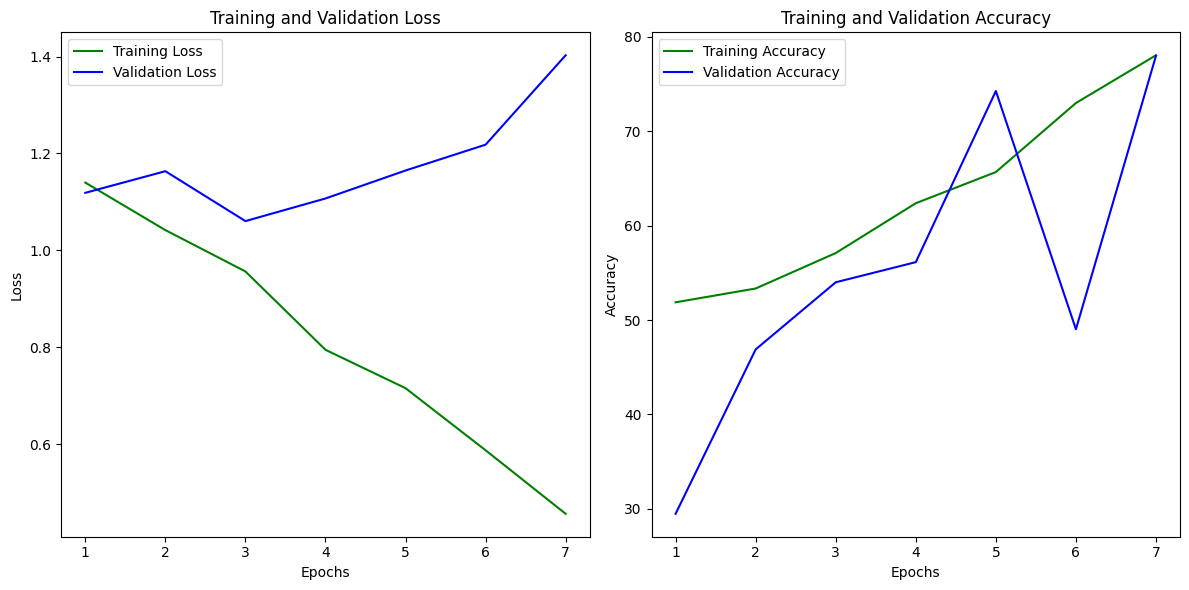


Epoch 8/50
-------------------------------
Epoch: 7, Learning Rate: 0.000500 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.355470, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 25.042017, correct predictions: 977, total: 1136
Batch 140/317 processed, running loss: 47.373072, correct predictions: 1943, total: 2256
Batch 210/317 processed, running loss: 67.126550, correct predictions: 2910, total: 3376
Batch 280/317 processed, running loss: 87.069824, correct predictions: 3886, total: 4496

Training Loss per batch = 0.302631	Accuracy on Training set = 86.961675% [4402/5062]

Validation Loss per batch = 1.273683	Accuracy on Validation set = 74.777975% [421/563]
Train Loss: 0.3026, Train Accuracy: 86.9617
Valid Loss: 1.2737, Valid Accuracy: 74.7780


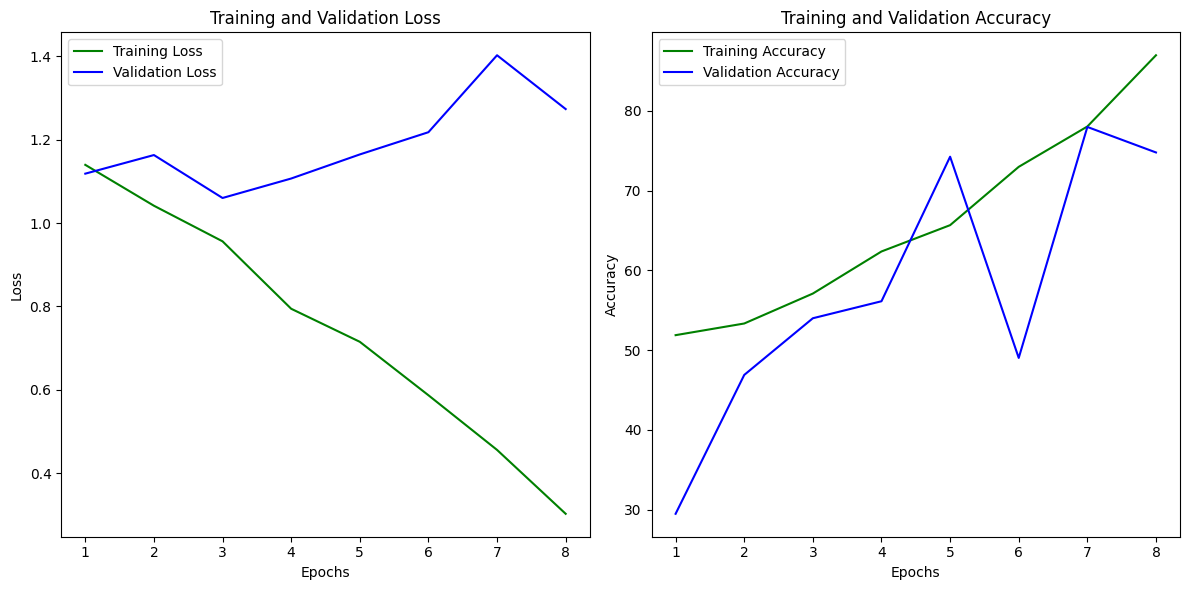


Epoch 9/50
-------------------------------
Epoch: 8, Learning Rate: 0.000500 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.542614, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 14.852666, correct predictions: 1032, total: 1136
Batch 140/317 processed, running loss: 31.827059, correct predictions: 2055, total: 2256
Batch 210/317 processed, running loss: 49.960287, correct predictions: 3058, total: 3376
Batch 280/317 processed, running loss: 66.760224, correct predictions: 4066, total: 4496

Training Loss per batch = 0.230198	Accuracy on Training set = 90.616357% [4587/5062]

Validation Loss per batch = 1.303645	Accuracy on Validation set = 75.133215% [423/563]
Train Loss: 0.2302, Train Accuracy: 90.6164
Valid Loss: 1.3036, Valid Accuracy: 75.1332


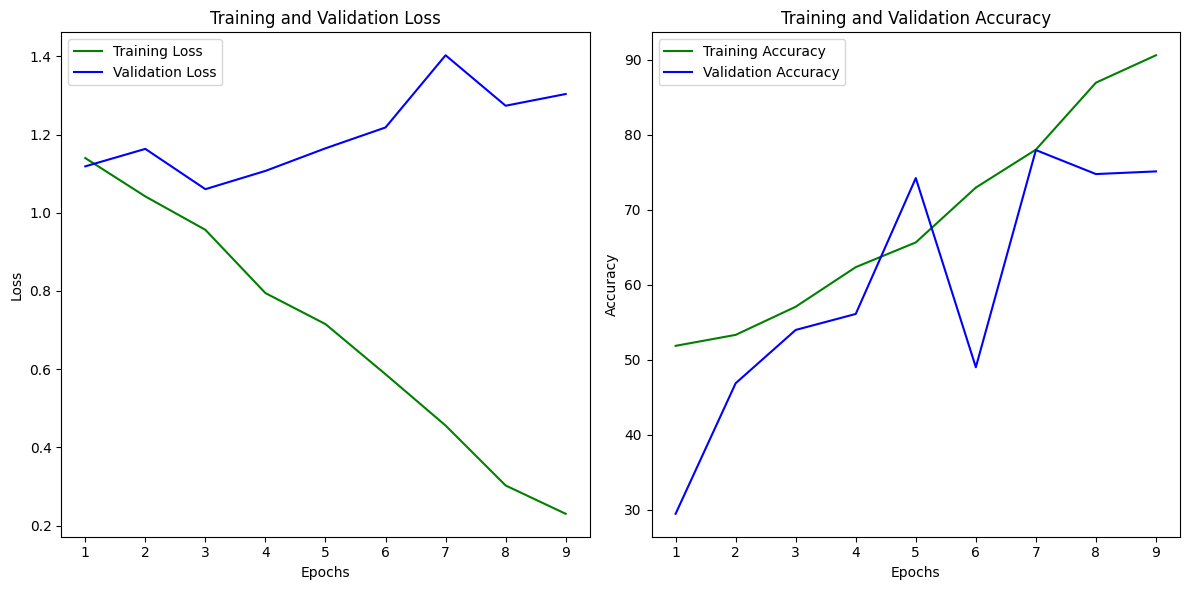


Epoch 10/50
-------------------------------
Epoch: 9, Learning Rate: 0.000500 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.070284, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 11.733797, correct predictions: 1057, total: 1136
Batch 140/317 processed, running loss: 25.854993, correct predictions: 2094, total: 2256
Batch 210/317 processed, running loss: 38.583520, correct predictions: 3156, total: 3376
Batch 280/317 processed, running loss: 53.498918, correct predictions: 4204, total: 4496

Training Loss per batch = 0.195177	Accuracy on Training set = 93.362307% [4726/5062]

Validation Loss per batch = 1.300798	Accuracy on Validation set = 75.310835% [424/563]
Train Loss: 0.1952, Train Accuracy: 93.3623
Valid Loss: 1.3008, Valid Accuracy: 75.3108


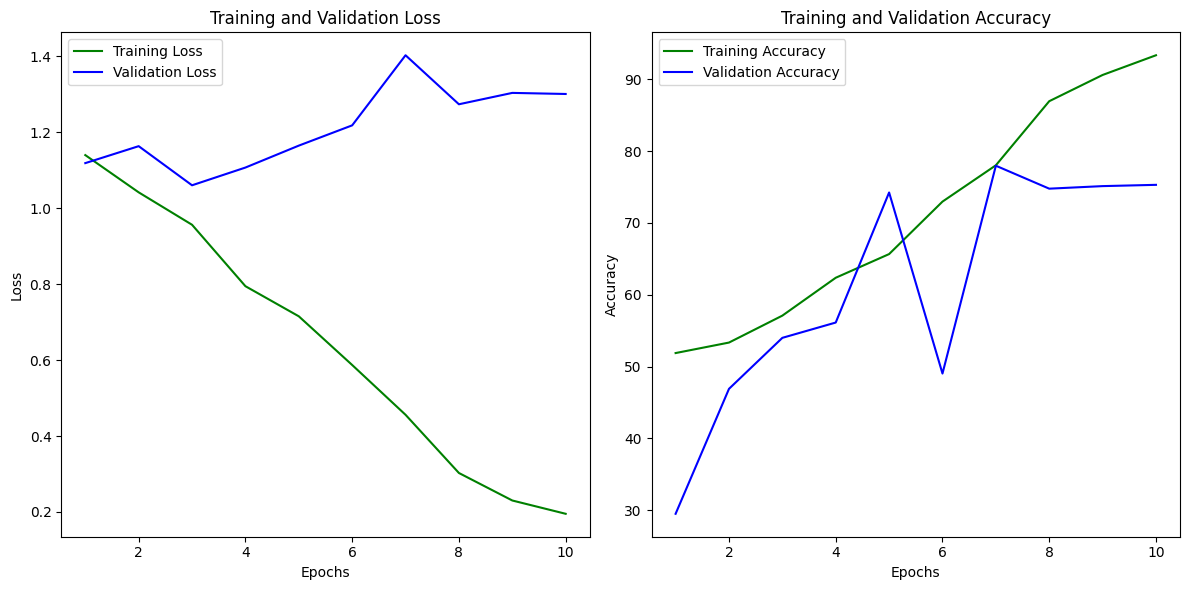


Epoch 11/50
-------------------------------
Epoch: 10, Learning Rate: 0.000500 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.162191, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 11.436145, correct predictions: 1066, total: 1136
Batch 140/317 processed, running loss: 22.778173, correct predictions: 2127, total: 2256
Batch 210/317 processed, running loss: 34.240990, correct predictions: 3179, total: 3376
Batch 280/317 processed, running loss: 48.104110, correct predictions: 4215, total: 4496

Training Loss per batch = 0.167816	Accuracy on Training set = 93.994469% [4758/5062]

Validation Loss per batch = 1.410827	Accuracy on Validation set = 77.797513% [438/563]
Train Loss: 0.1678, Train Accuracy: 93.9945
Valid Loss: 1.4108, Valid Accuracy: 77.7975


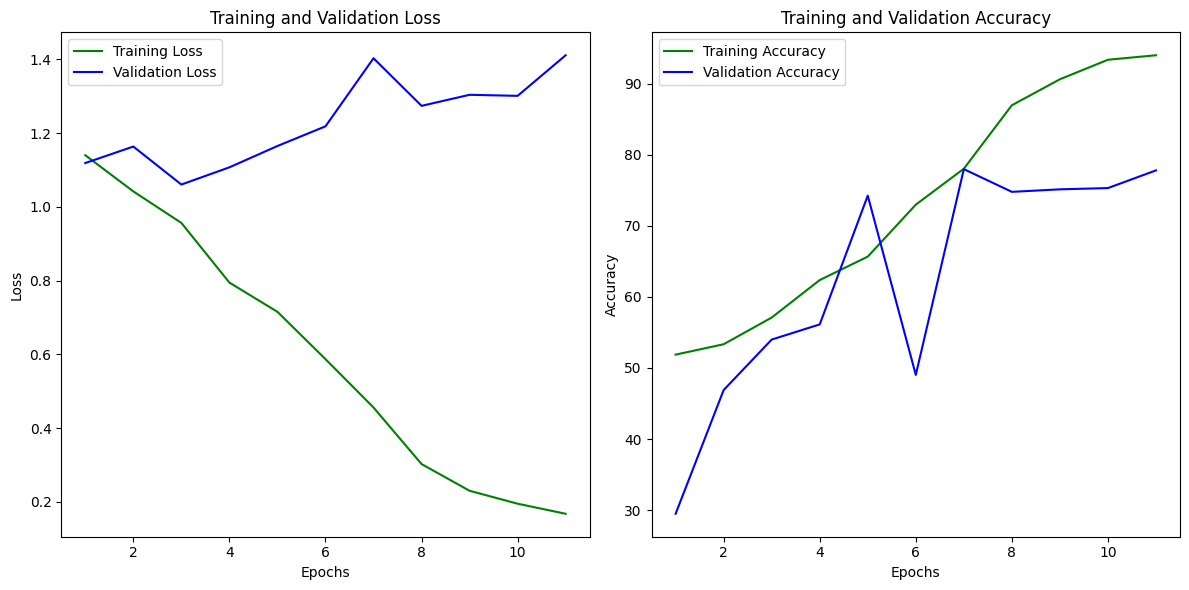


Epoch 12/50
-------------------------------
Epoch: 11, Learning Rate: 0.000050 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.029970, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 11.130619, correct predictions: 1067, total: 1136
Batch 140/317 processed, running loss: 22.295280, correct predictions: 2120, total: 2256
Batch 210/317 processed, running loss: 31.890404, correct predictions: 3200, total: 3376
Batch 280/317 processed, running loss: 41.536395, correct predictions: 4266, total: 4496

Training Loss per batch = 0.146001	Accuracy on Training set = 95.080996% [4813/5062]

Validation Loss per batch = 1.407906	Accuracy on Validation set = 77.264654% [435/563]
Train Loss: 0.1460, Train Accuracy: 95.0810
Valid Loss: 1.4079, Valid Accuracy: 77.2647


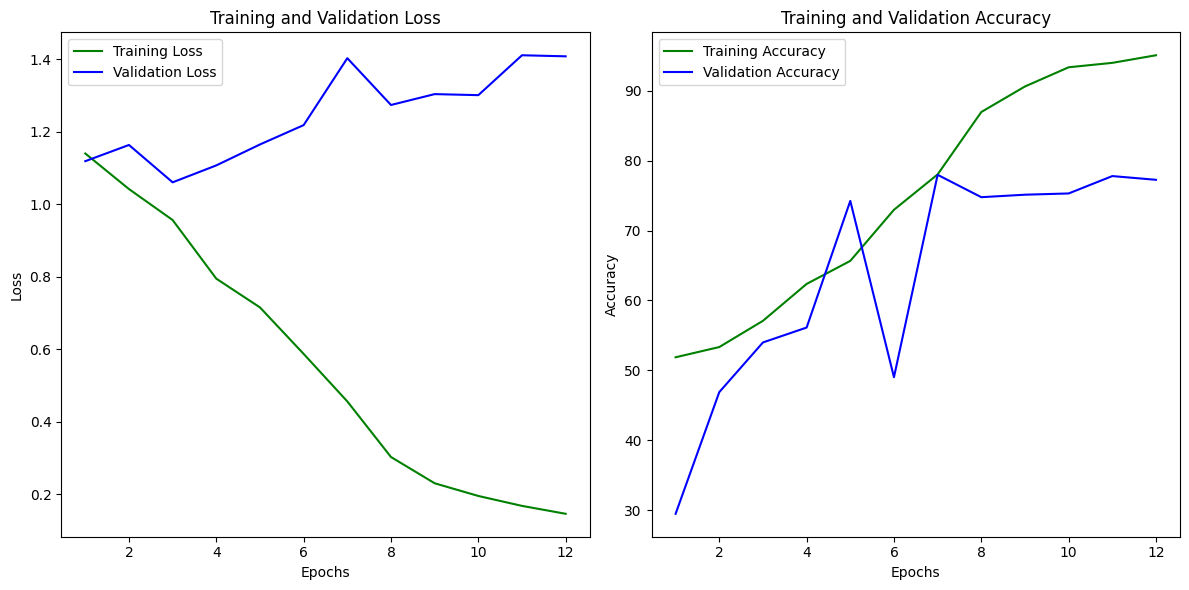


Epoch 13/50
-------------------------------
Epoch: 12, Learning Rate: 0.000050 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.147145, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.433256, correct predictions: 1076, total: 1136
Batch 140/317 processed, running loss: 20.355466, correct predictions: 2149, total: 2256
Batch 210/317 processed, running loss: 30.643269, correct predictions: 3208, total: 3376
Batch 280/317 processed, running loss: 42.218039, correct predictions: 4249, total: 4496

Training Loss per batch = 0.149841	Accuracy on Training set = 94.705650% [4794/5062]

Validation Loss per batch = 1.417499	Accuracy on Validation set = 78.330373% [441/563]
Train Loss: 0.1498, Train Accuracy: 94.7056
Valid Loss: 1.4175, Valid Accuracy: 78.3304


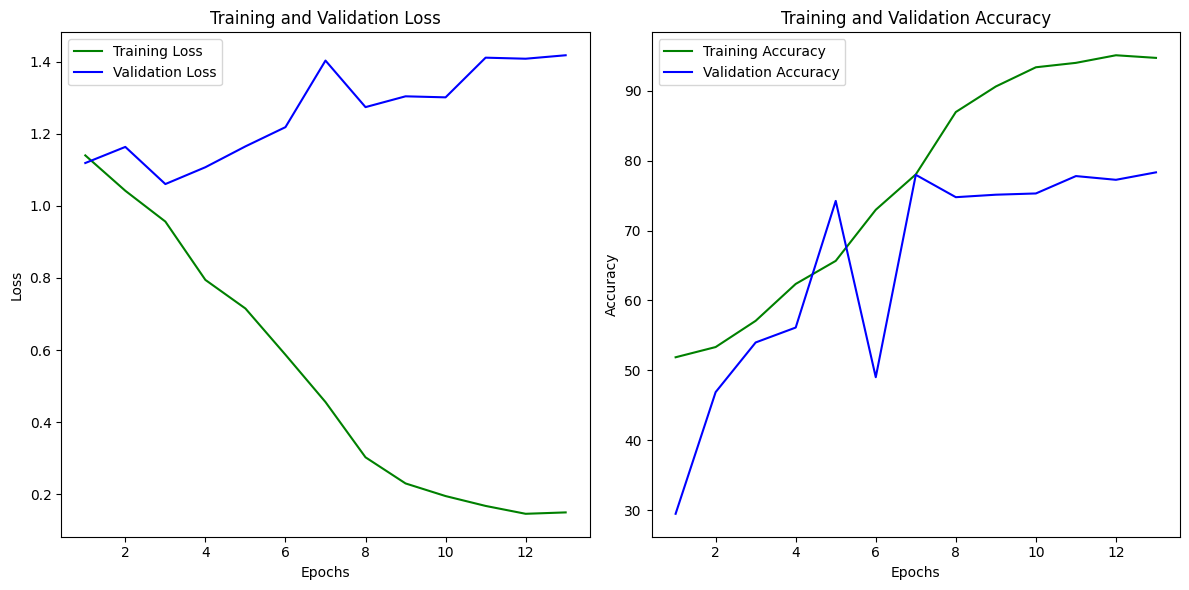


Epoch 14/50
-------------------------------
Epoch: 13, Learning Rate: 0.000050 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.168328, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 8.980414, correct predictions: 1090, total: 1136
Batch 140/317 processed, running loss: 19.140877, correct predictions: 2153, total: 2256
Batch 210/317 processed, running loss: 29.398624, correct predictions: 3223, total: 3376
Batch 280/317 processed, running loss: 40.069990, correct predictions: 4273, total: 4496

Training Loss per batch = 0.142575	Accuracy on Training set = 95.120506% [4815/5062]

Validation Loss per batch = 1.420166	Accuracy on Validation set = 78.152753% [440/563]
Train Loss: 0.1426, Train Accuracy: 95.1205
Valid Loss: 1.4202, Valid Accuracy: 78.1528


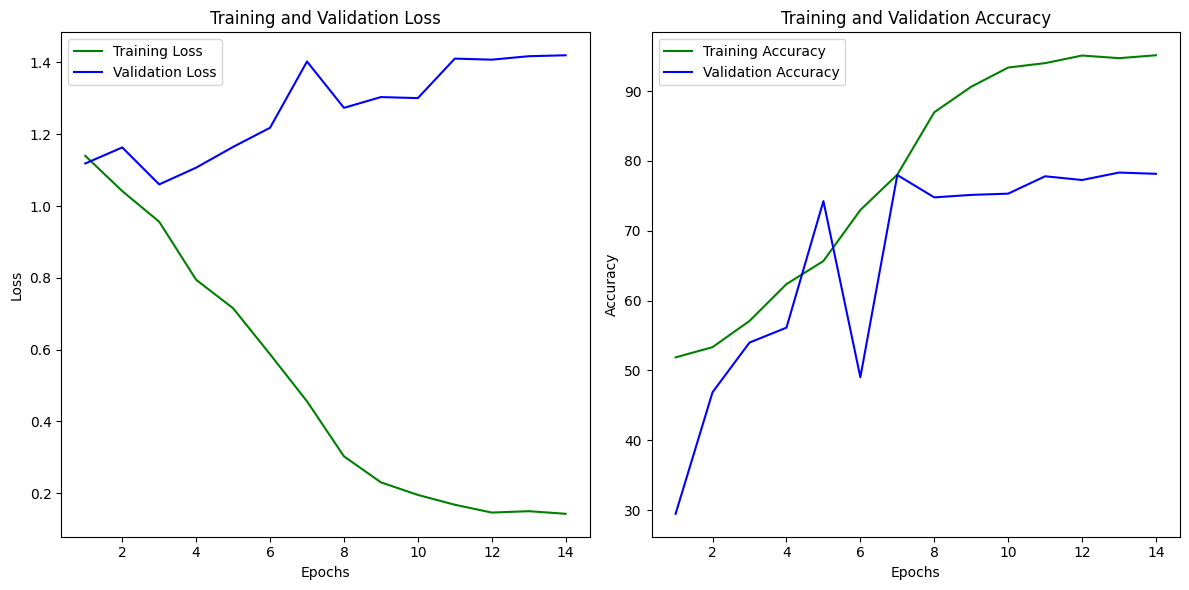


Epoch 15/50
-------------------------------
Epoch: 14, Learning Rate: 0.000050 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.089812, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.226836, correct predictions: 1087, total: 1136
Batch 140/317 processed, running loss: 19.697131, correct predictions: 2157, total: 2256
Batch 210/317 processed, running loss: 28.598265, correct predictions: 3231, total: 3376
Batch 280/317 processed, running loss: 38.221818, correct predictions: 4311, total: 4496

Training Loss per batch = 0.136797	Accuracy on Training set = 95.732912% [4846/5062]

Validation Loss per batch = 1.394401	Accuracy on Validation set = 78.330373% [441/563]
Train Loss: 0.1368, Train Accuracy: 95.7329
Valid Loss: 1.3944, Valid Accuracy: 78.3304


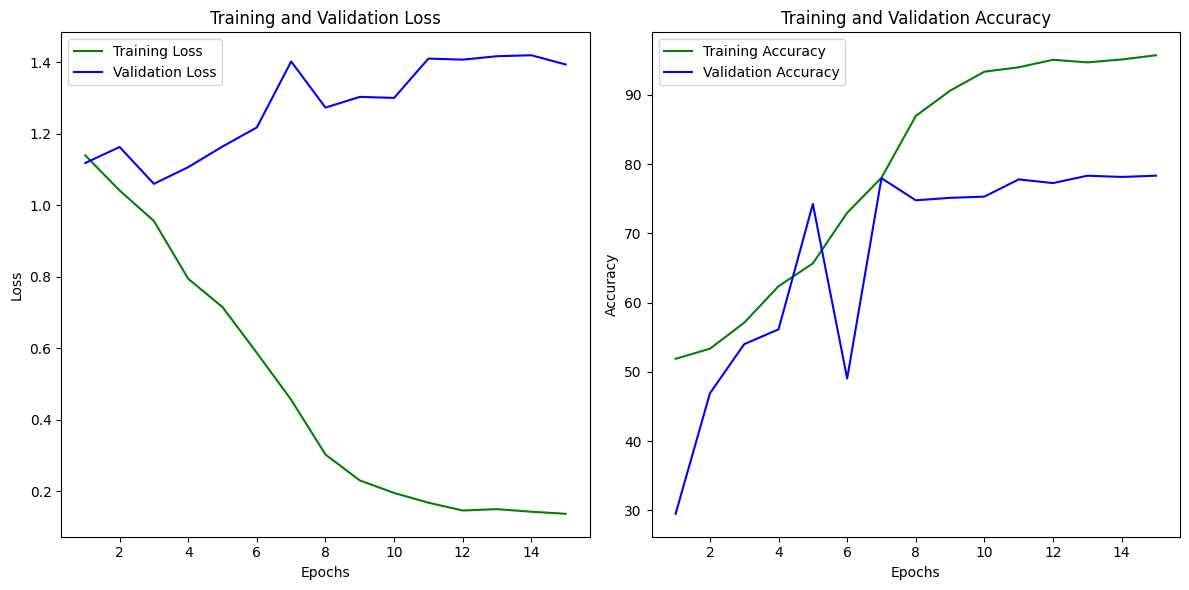


Epoch 16/50
-------------------------------
Epoch: 15, Learning Rate: 0.000005 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.227714, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 10.365616, correct predictions: 1080, total: 1136
Batch 140/317 processed, running loss: 19.484109, correct predictions: 2154, total: 2256
Batch 210/317 processed, running loss: 28.527004, correct predictions: 3226, total: 3376
Batch 280/317 processed, running loss: 38.576155, correct predictions: 4290, total: 4496

Training Loss per batch = 0.139019	Accuracy on Training set = 95.357566% [4827/5062]

Validation Loss per batch = 1.358131	Accuracy on Validation set = 76.376554% [430/563]
Train Loss: 0.1390, Train Accuracy: 95.3576
Valid Loss: 1.3581, Valid Accuracy: 76.3766


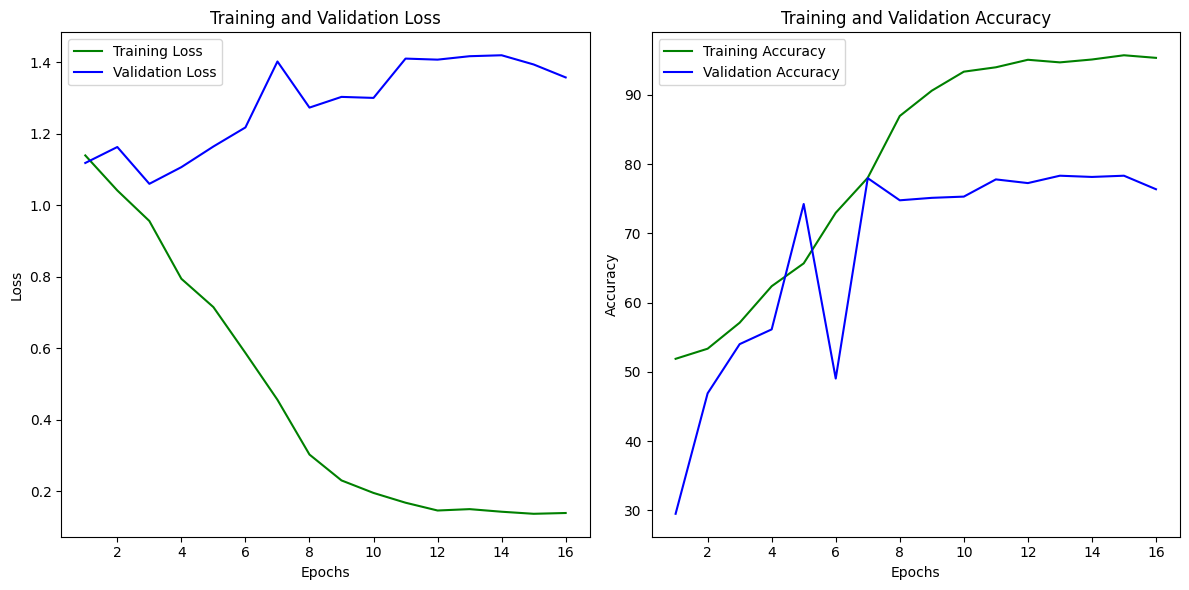


Epoch 17/50
-------------------------------
Epoch: 16, Learning Rate: 0.000005 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.046564, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.175657, correct predictions: 1076, total: 1136
Batch 140/317 processed, running loss: 19.657216, correct predictions: 2130, total: 2256
Batch 210/317 processed, running loss: 29.414286, correct predictions: 3193, total: 3376
Batch 280/317 processed, running loss: 38.995063, correct predictions: 4265, total: 4496

Training Loss per batch = 0.139765	Accuracy on Training set = 95.001976% [4809/5062]

Validation Loss per batch = 1.372732	Accuracy on Validation set = 77.797513% [438/563]
Train Loss: 0.1398, Train Accuracy: 95.0020
Valid Loss: 1.3727, Valid Accuracy: 77.7975


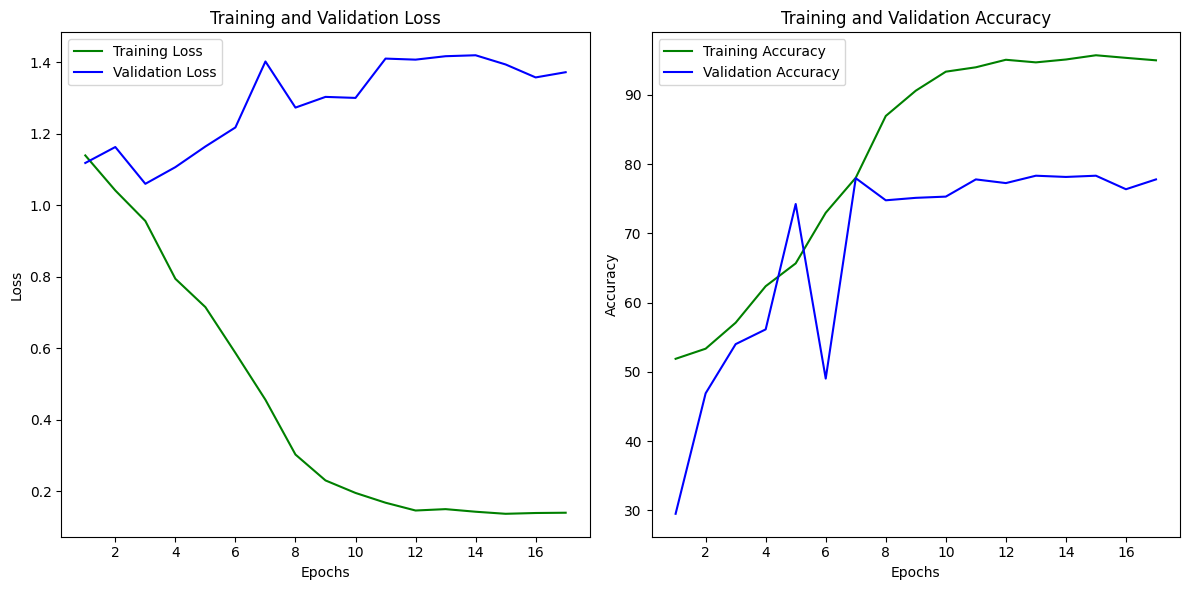


Epoch 18/50
-------------------------------
Epoch: 17, Learning Rate: 0.000005 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.139489, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.804076, correct predictions: 1079, total: 1136
Batch 140/317 processed, running loss: 19.660013, correct predictions: 2148, total: 2256
Batch 210/317 processed, running loss: 29.820512, correct predictions: 3198, total: 3376
Batch 280/317 processed, running loss: 39.795958, correct predictions: 4264, total: 4496

Training Loss per batch = 0.140095	Accuracy on Training set = 94.903200% [4804/5062]

Validation Loss per batch = 1.356380	Accuracy on Validation set = 76.909414% [433/563]
Train Loss: 0.1401, Train Accuracy: 94.9032
Valid Loss: 1.3564, Valid Accuracy: 76.9094


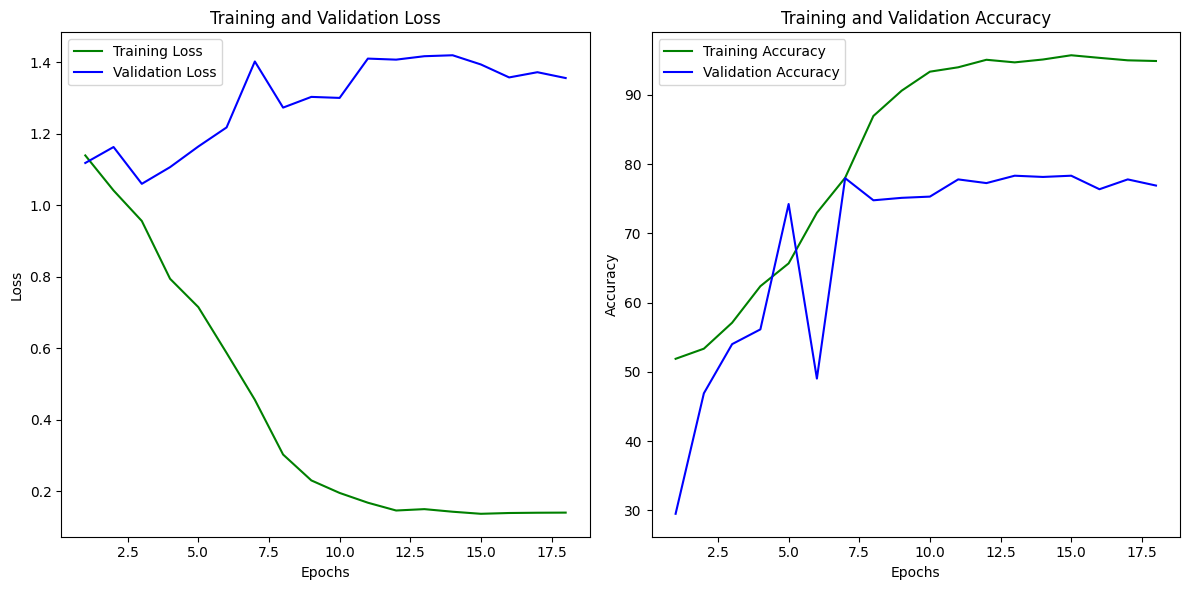


Epoch 19/50
-------------------------------
Epoch: 18, Learning Rate: 0.000005 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.125951, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 12.128161, correct predictions: 1075, total: 1136
Batch 140/317 processed, running loss: 21.915713, correct predictions: 2139, total: 2256
Batch 210/317 processed, running loss: 30.946932, correct predictions: 3213, total: 3376
Batch 280/317 processed, running loss: 40.897048, correct predictions: 4288, total: 4496

Training Loss per batch = 0.145833	Accuracy on Training set = 95.318056% [4825/5062]

Validation Loss per batch = 1.357276	Accuracy on Validation set = 75.666075% [426/563]
Train Loss: 0.1458, Train Accuracy: 95.3181
Valid Loss: 1.3573, Valid Accuracy: 75.6661


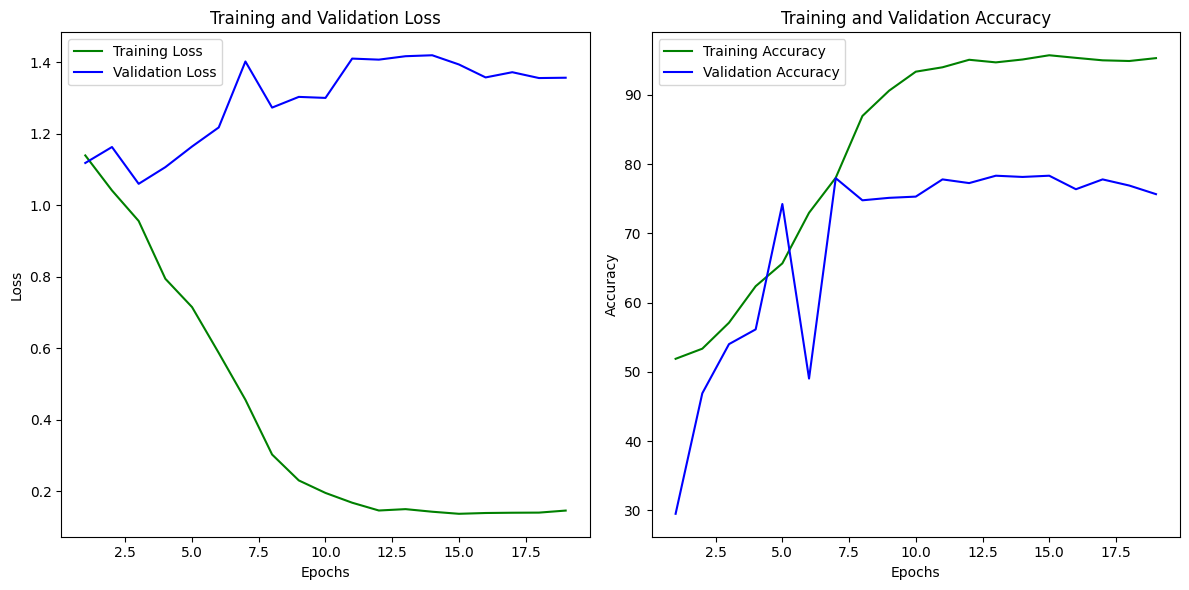


Epoch 20/50
-------------------------------
Epoch: 19, Learning Rate: 0.000001 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.131492, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 8.992119, correct predictions: 1082, total: 1136
Batch 140/317 processed, running loss: 18.151128, correct predictions: 2156, total: 2256
Batch 210/317 processed, running loss: 28.027301, correct predictions: 3222, total: 3376
Batch 280/317 processed, running loss: 39.748445, correct predictions: 4290, total: 4496

Training Loss per batch = 0.141167	Accuracy on Training set = 95.436586% [4831/5062]

Validation Loss per batch = 1.402972	Accuracy on Validation set = 77.619893% [437/563]
Train Loss: 0.1412, Train Accuracy: 95.4366
Valid Loss: 1.4030, Valid Accuracy: 77.6199


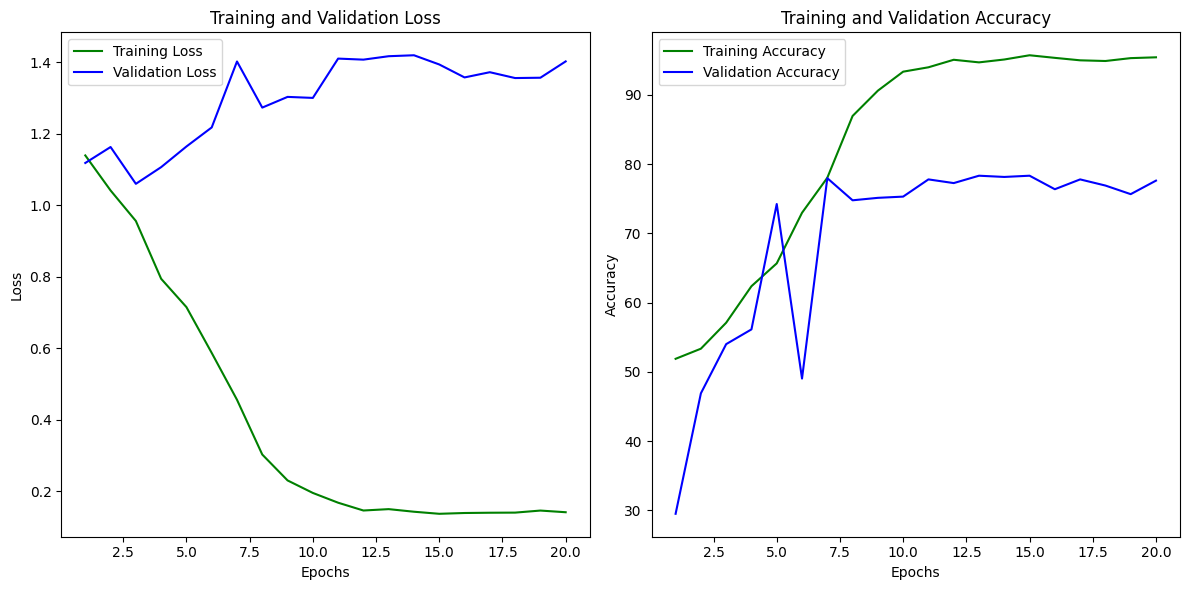


Epoch 21/50
-------------------------------
Epoch: 20, Learning Rate: 0.000001 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.151894, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 10.181871, correct predictions: 1077, total: 1136
Batch 140/317 processed, running loss: 20.002328, correct predictions: 2138, total: 2256
Batch 210/317 processed, running loss: 29.990922, correct predictions: 3201, total: 3376
Batch 280/317 processed, running loss: 39.773468, correct predictions: 4263, total: 4496

Training Loss per batch = 0.140534	Accuracy on Training set = 94.764915% [4797/5062]

Validation Loss per batch = 1.375123	Accuracy on Validation set = 76.376554% [430/563]
Train Loss: 0.1405, Train Accuracy: 94.7649
Valid Loss: 1.3751, Valid Accuracy: 76.3766


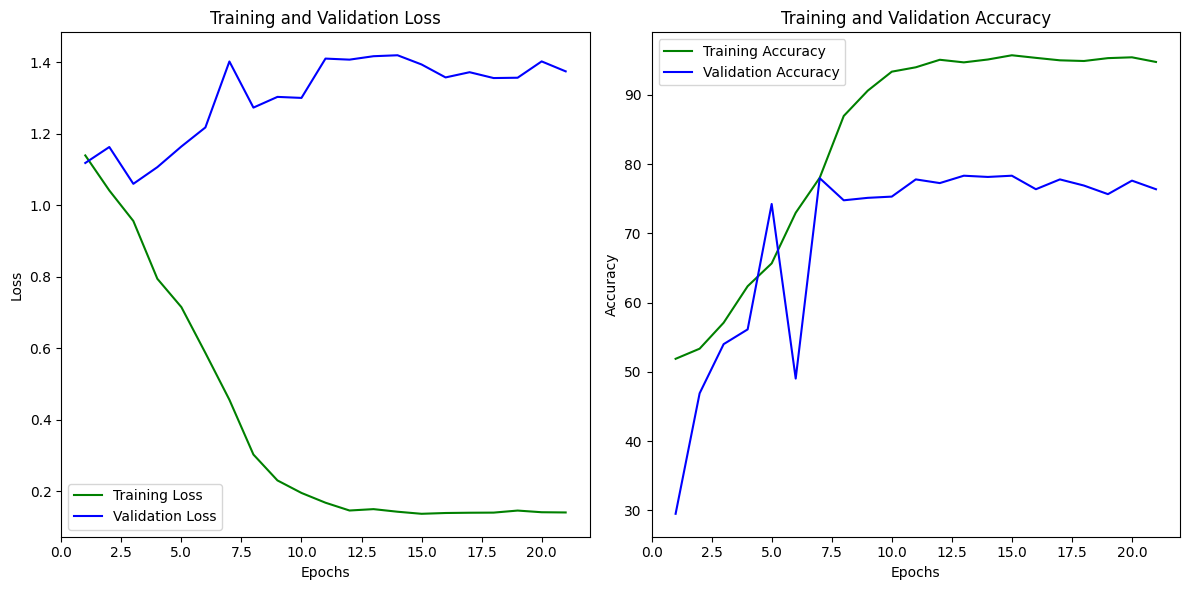


Epoch 22/50
-------------------------------
Epoch: 21, Learning Rate: 0.000001 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.067921, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 10.367856, correct predictions: 1067, total: 1136
Batch 140/317 processed, running loss: 19.800737, correct predictions: 2134, total: 2256
Batch 210/317 processed, running loss: 30.285293, correct predictions: 3202, total: 3376
Batch 280/317 processed, running loss: 40.400188, correct predictions: 4265, total: 4496

Training Loss per batch = 0.145211	Accuracy on Training set = 94.705650% [4794/5062]

Validation Loss per batch = 1.390207	Accuracy on Validation set = 76.376554% [430/563]
Train Loss: 0.1452, Train Accuracy: 94.7056
Valid Loss: 1.3902, Valid Accuracy: 76.3766


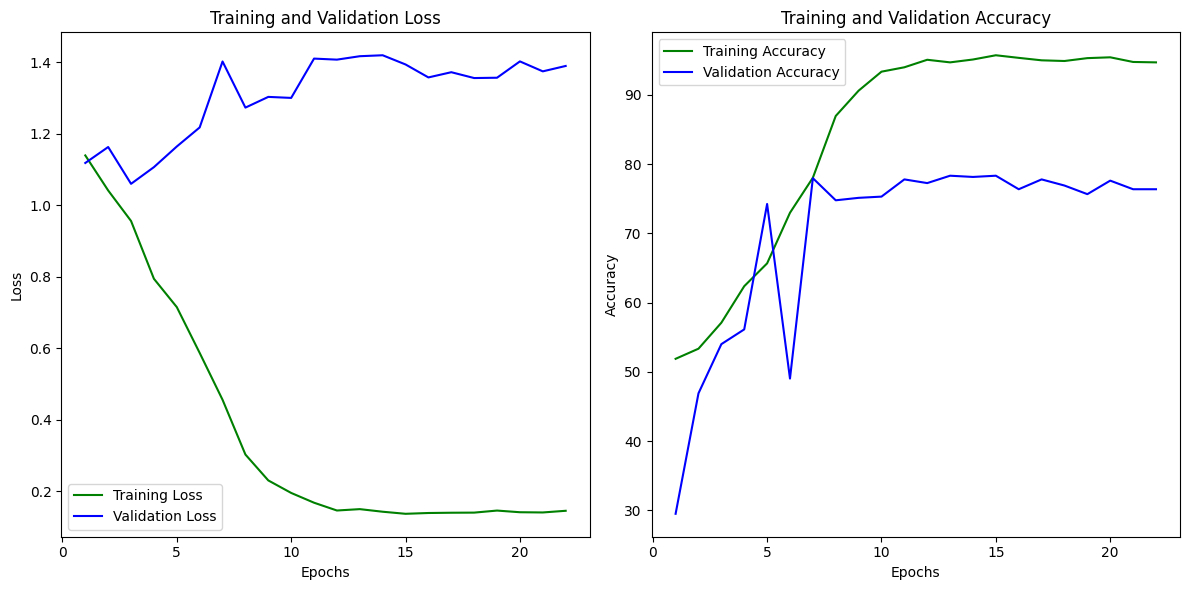


Epoch 23/50
-------------------------------
Epoch: 22, Learning Rate: 0.000001 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.029115, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.124810, correct predictions: 1085, total: 1136
Batch 140/317 processed, running loss: 19.687152, correct predictions: 2159, total: 2256
Batch 210/317 processed, running loss: 29.044956, correct predictions: 3234, total: 3376
Batch 280/317 processed, running loss: 37.702252, correct predictions: 4314, total: 4496

Training Loss per batch = 0.137981	Accuracy on Training set = 95.851442% [4852/5062]

Validation Loss per batch = 1.366710	Accuracy on Validation set = 77.619893% [437/563]
Train Loss: 0.1380, Train Accuracy: 95.8514
Valid Loss: 1.3667, Valid Accuracy: 77.6199


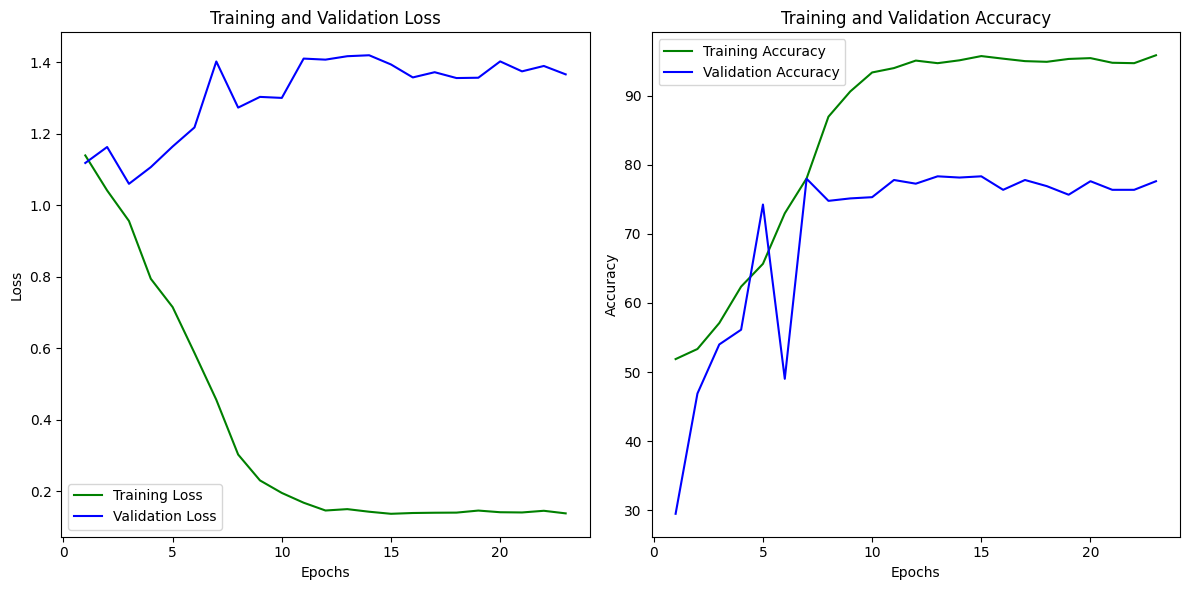


Epoch 24/50
-------------------------------
Epoch: 23, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.075068, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 8.357156, correct predictions: 1100, total: 1136
Batch 140/317 processed, running loss: 18.496865, correct predictions: 2168, total: 2256
Batch 210/317 processed, running loss: 29.459737, correct predictions: 3229, total: 3376
Batch 280/317 processed, running loss: 38.139320, correct predictions: 4303, total: 4496

Training Loss per batch = 0.134637	Accuracy on Training set = 95.634137% [4841/5062]

Validation Loss per batch = 1.454253	Accuracy on Validation set = 79.218472% [446/563]
Train Loss: 0.1346, Train Accuracy: 95.6341
Valid Loss: 1.4543, Valid Accuracy: 79.2185


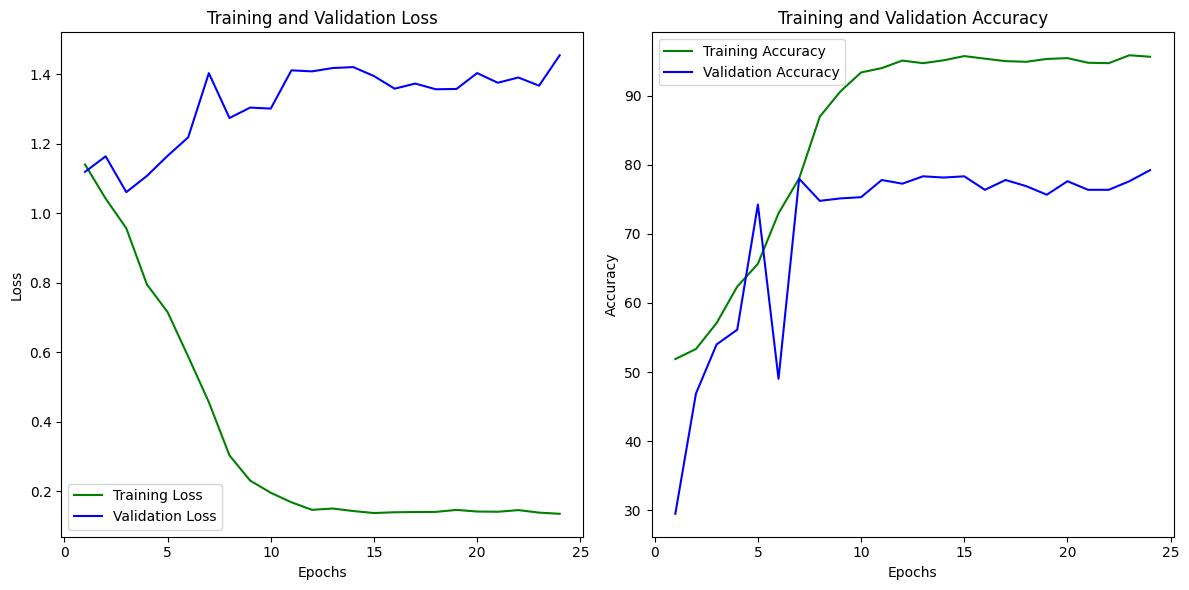


Epoch 25/50
-------------------------------
Epoch: 24, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.229673, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 10.971540, correct predictions: 1074, total: 1136
Batch 140/317 processed, running loss: 21.202453, correct predictions: 2147, total: 2256
Batch 210/317 processed, running loss: 30.879289, correct predictions: 3215, total: 3376
Batch 280/317 processed, running loss: 40.300886, correct predictions: 4275, total: 4496

Training Loss per batch = 0.144021	Accuracy on Training set = 95.100751% [4814/5062]

Validation Loss per batch = 1.399199	Accuracy on Validation set = 77.442274% [436/563]
Train Loss: 0.1440, Train Accuracy: 95.1008
Valid Loss: 1.3992, Valid Accuracy: 77.4423


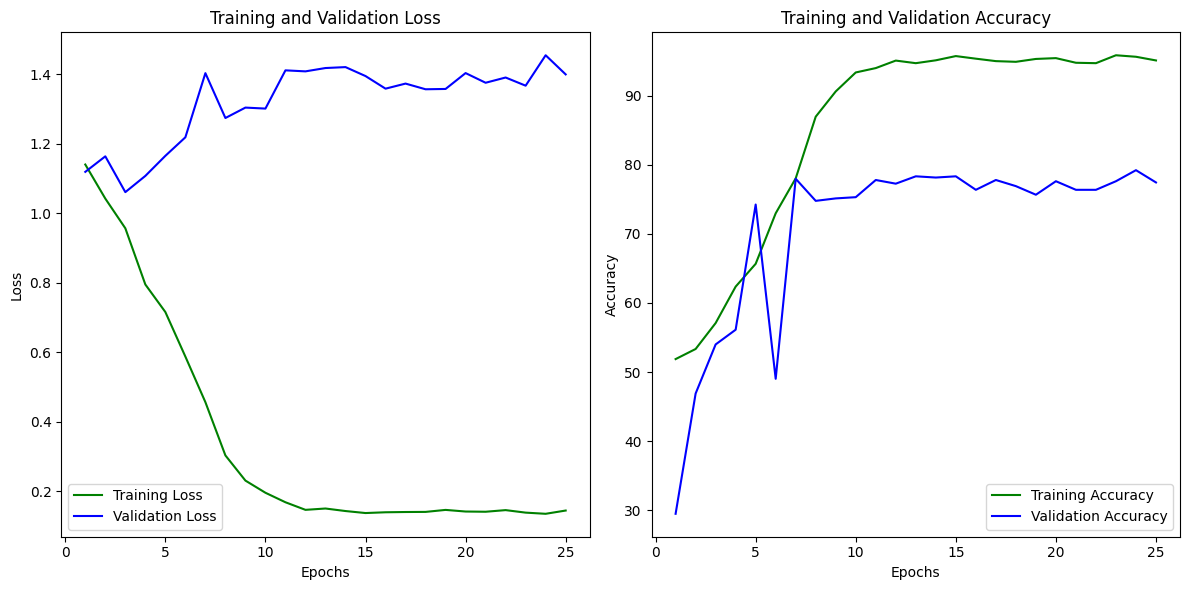


Epoch 26/50
-------------------------------
Epoch: 25, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.195327, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 10.047988, correct predictions: 1079, total: 1136
Batch 140/317 processed, running loss: 19.974318, correct predictions: 2139, total: 2256
Batch 210/317 processed, running loss: 28.520541, correct predictions: 3209, total: 3376
Batch 280/317 processed, running loss: 38.815187, correct predictions: 4279, total: 4496

Training Loss per batch = 0.139635	Accuracy on Training set = 94.962465% [4807/5062]

Validation Loss per batch = 1.407237	Accuracy on Validation set = 77.442274% [436/563]
Train Loss: 0.1396, Train Accuracy: 94.9625
Valid Loss: 1.4072, Valid Accuracy: 77.4423


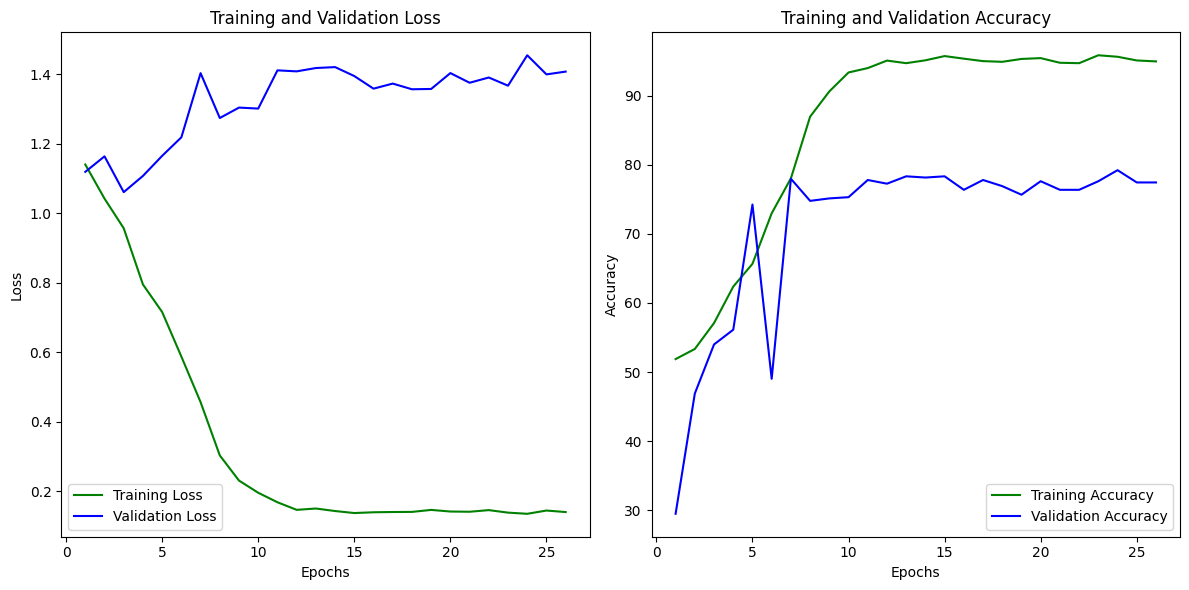


Epoch 27/50
-------------------------------
Epoch: 26, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.062340, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.344611, correct predictions: 1086, total: 1136
Batch 140/317 processed, running loss: 19.617485, correct predictions: 2158, total: 2256
Batch 210/317 processed, running loss: 28.153981, correct predictions: 3228, total: 3376
Batch 280/317 processed, running loss: 39.088211, correct predictions: 4282, total: 4496

Training Loss per batch = 0.143718	Accuracy on Training set = 95.080996% [4813/5062]

Validation Loss per batch = 1.418651	Accuracy on Validation set = 78.152753% [440/563]
Train Loss: 0.1437, Train Accuracy: 95.0810
Valid Loss: 1.4187, Valid Accuracy: 78.1528


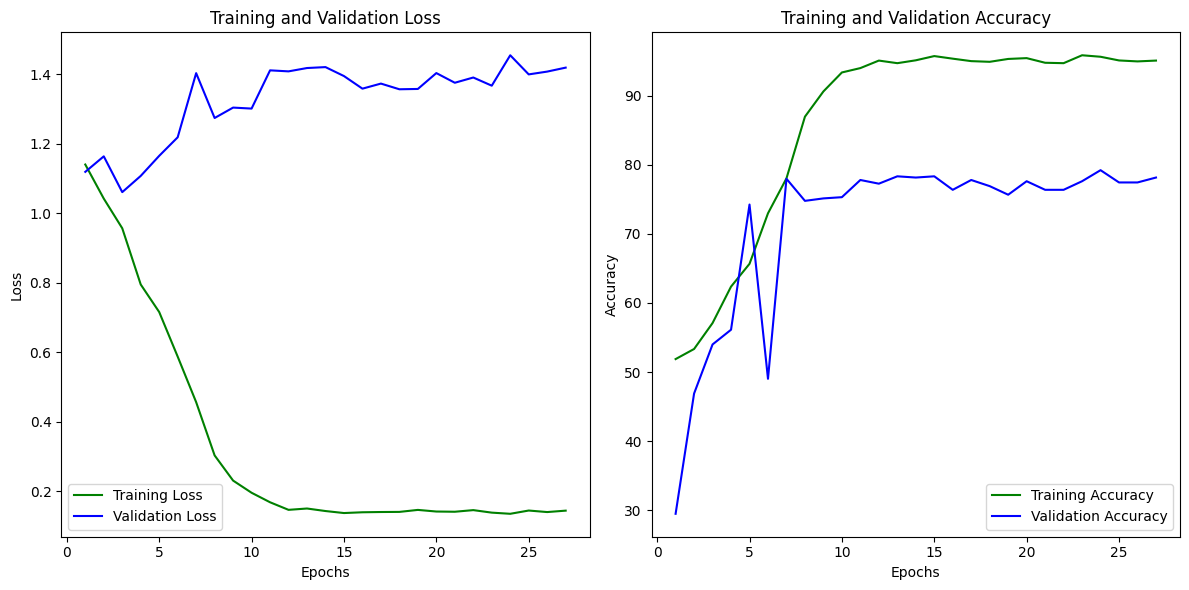


Epoch 28/50
-------------------------------
Epoch: 27, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.035025, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 11.286068, correct predictions: 1076, total: 1136
Batch 140/317 processed, running loss: 21.207506, correct predictions: 2145, total: 2256
Batch 210/317 processed, running loss: 32.142437, correct predictions: 3214, total: 3376
Batch 280/317 processed, running loss: 40.579655, correct predictions: 4292, total: 4496

Training Loss per batch = 0.142366	Accuracy on Training set = 95.555117% [4837/5062]

Validation Loss per batch = 1.399207	Accuracy on Validation set = 77.264654% [435/563]
Train Loss: 0.1424, Train Accuracy: 95.5551
Valid Loss: 1.3992, Valid Accuracy: 77.2647


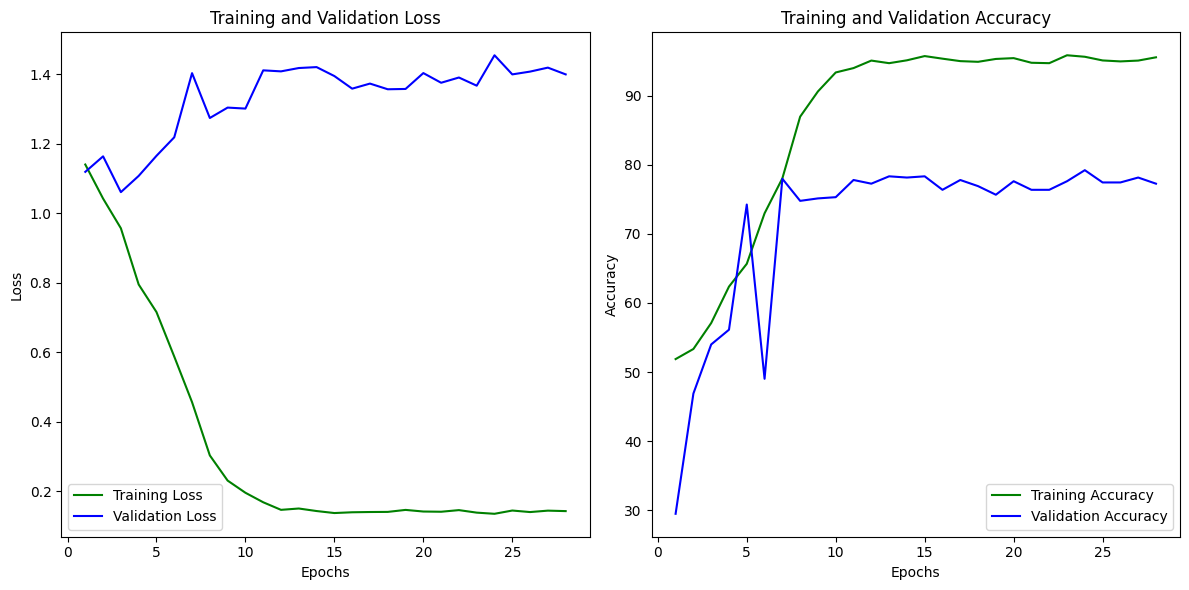


Epoch 29/50
-------------------------------
Epoch: 28, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.113087, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 9.262171, correct predictions: 1089, total: 1136
Batch 140/317 processed, running loss: 18.688896, correct predictions: 2158, total: 2256
Batch 210/317 processed, running loss: 27.902243, correct predictions: 3227, total: 3376
Batch 280/317 processed, running loss: 39.767817, correct predictions: 4291, total: 4496

Training Loss per batch = 0.138805	Accuracy on Training set = 95.673647% [4843/5062]

Validation Loss per batch = 1.393283	Accuracy on Validation set = 77.264654% [435/563]
Train Loss: 0.1388, Train Accuracy: 95.6736
Valid Loss: 1.3933, Valid Accuracy: 77.2647


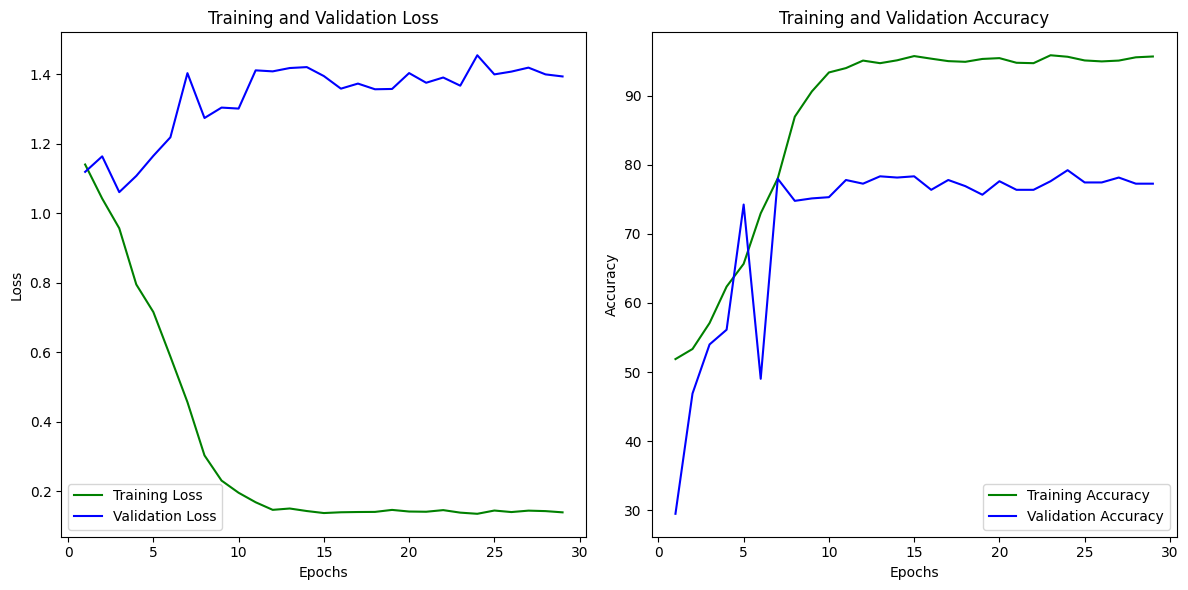


Epoch 30/50
-------------------------------
Epoch: 29, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.079528, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 9.707580, correct predictions: 1083, total: 1136
Batch 140/317 processed, running loss: 18.987828, correct predictions: 2152, total: 2256
Batch 210/317 processed, running loss: 29.438786, correct predictions: 3215, total: 3376
Batch 280/317 processed, running loss: 39.349761, correct predictions: 4287, total: 4496

Training Loss per batch = 0.140212	Accuracy on Training set = 95.397076% [4829/5062]

Validation Loss per batch = 1.421356	Accuracy on Validation set = 78.863233% [444/563]
Train Loss: 0.1402, Train Accuracy: 95.3971
Valid Loss: 1.4214, Valid Accuracy: 78.8632


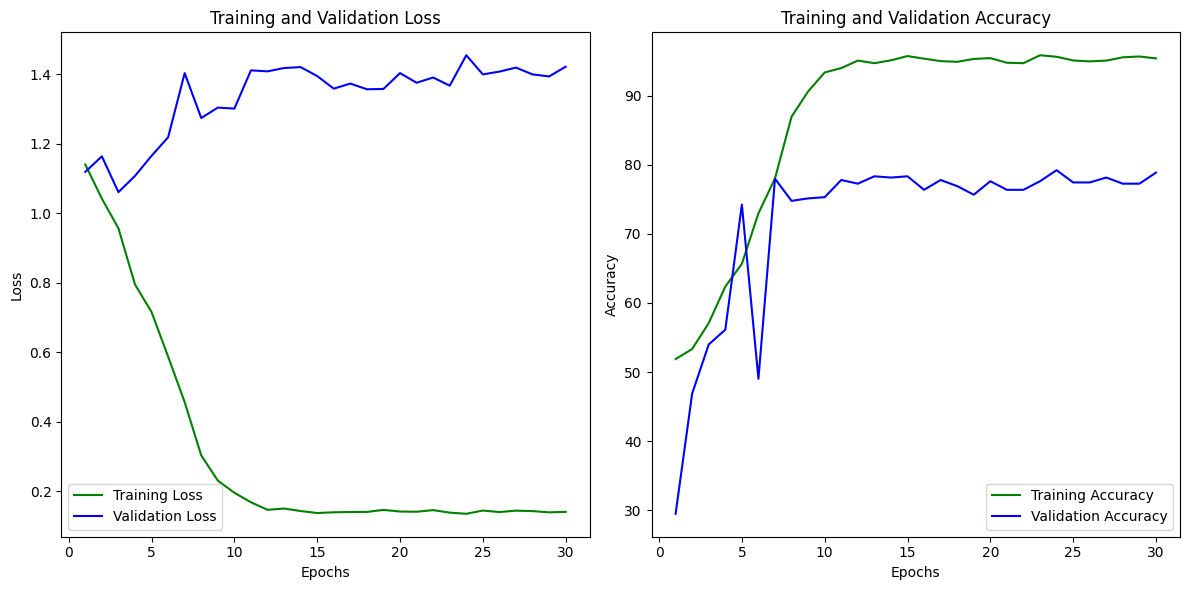


Epoch 31/50
-------------------------------
Epoch: 30, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.167984, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 11.086708, correct predictions: 1079, total: 1136
Batch 140/317 processed, running loss: 20.433855, correct predictions: 2149, total: 2256
Batch 210/317 processed, running loss: 29.291624, correct predictions: 3226, total: 3376
Batch 280/317 processed, running loss: 38.804475, correct predictions: 4282, total: 4496

Training Loss per batch = 0.136128	Accuracy on Training set = 95.258791% [4822/5062]

Validation Loss per batch = 1.387351	Accuracy on Validation set = 77.442274% [436/563]
Train Loss: 0.1361, Train Accuracy: 95.2588
Valid Loss: 1.3874, Valid Accuracy: 77.4423


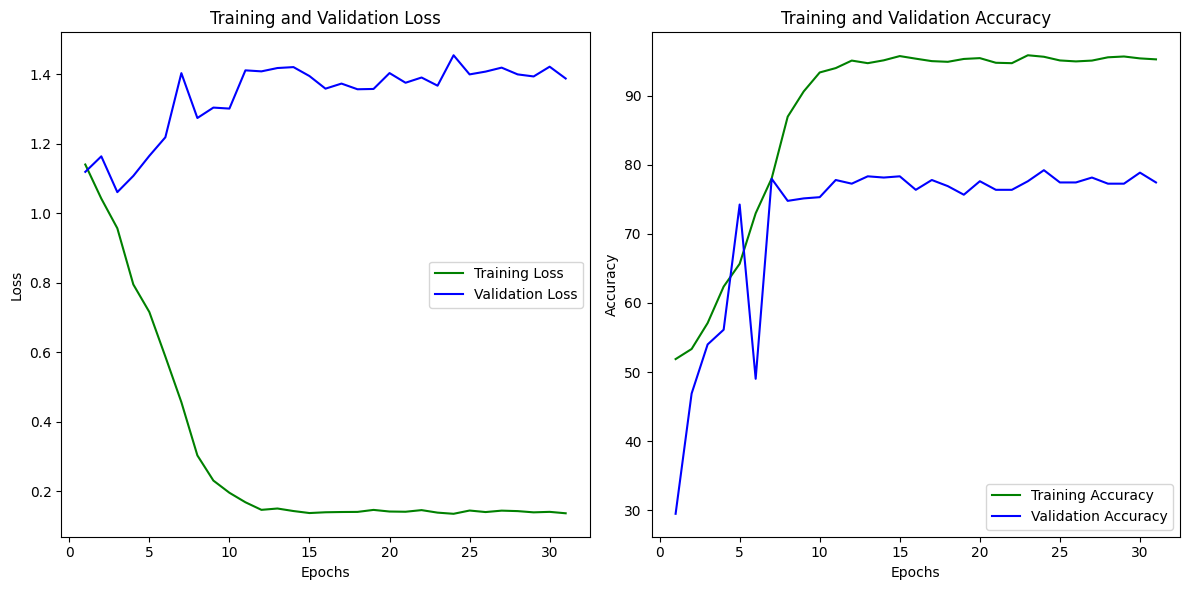


Epoch 32/50
-------------------------------
Epoch: 31, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.122052, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.638585, correct predictions: 1081, total: 1136
Batch 140/317 processed, running loss: 19.352291, correct predictions: 2155, total: 2256
Batch 210/317 processed, running loss: 29.231761, correct predictions: 3223, total: 3376
Batch 280/317 processed, running loss: 38.696600, correct predictions: 4285, total: 4496

Training Loss per batch = 0.137736	Accuracy on Training set = 95.416831% [4830/5062]

Validation Loss per batch = 1.396446	Accuracy on Validation set = 76.731794% [432/563]
Train Loss: 0.1377, Train Accuracy: 95.4168
Valid Loss: 1.3964, Valid Accuracy: 76.7318


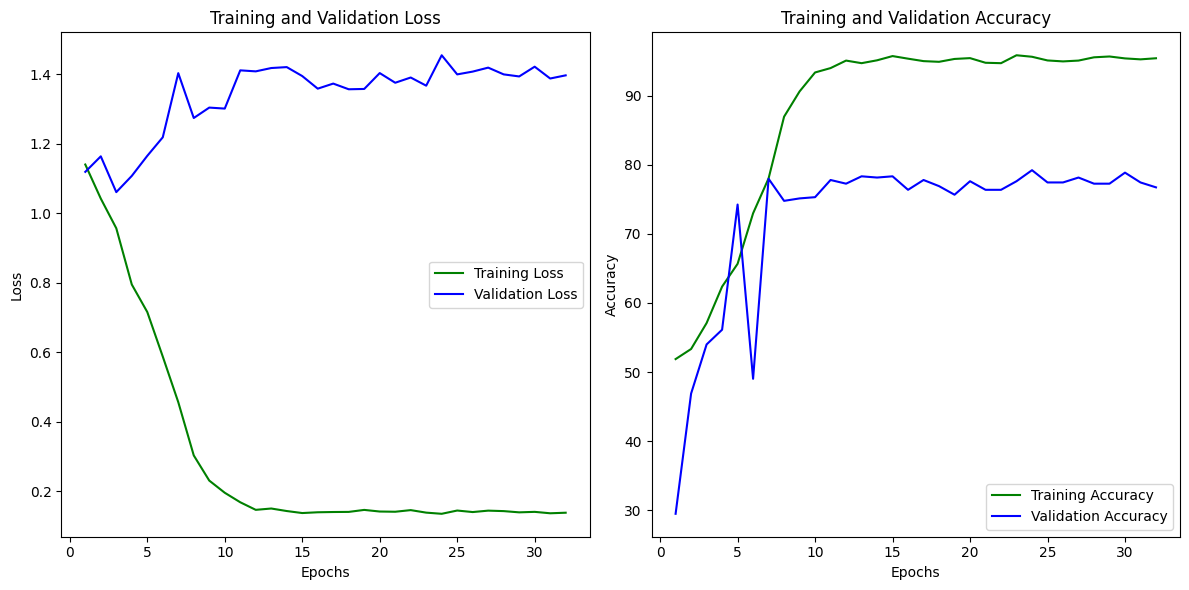


Epoch 33/50
-------------------------------
Epoch: 32, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.167988, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 9.919543, correct predictions: 1085, total: 1136
Batch 140/317 processed, running loss: 20.650053, correct predictions: 2151, total: 2256
Batch 210/317 processed, running loss: 31.923876, correct predictions: 3211, total: 3376
Batch 210/317 processed, running loss: 31.923876, correct predictions: 3211, total: 3376
Batch 280/317 processed, running loss: 41.731403, correct predictions: 4279, total: 4496
Batch 280/317 processed, running loss: 41.731403, correct predictions: 4279, total: 4496

Training Loss per batch = 0.146946	Accuracy on Training set = 95.061241% [4812/5062]

Training Loss per batch = 0.146946	Accuracy on Training set = 95.061241% [4812/5062]

Validation Loss per batch = 1.373442	Accuracy on Validation set = 76.554174% [431/563]
Train Loss: 0.1469, Train Accuracy: 95.0612
Valid Loss: 1.3734, Valid Accuracy: 76.5542

Validation Loss per batch = 1.373442	

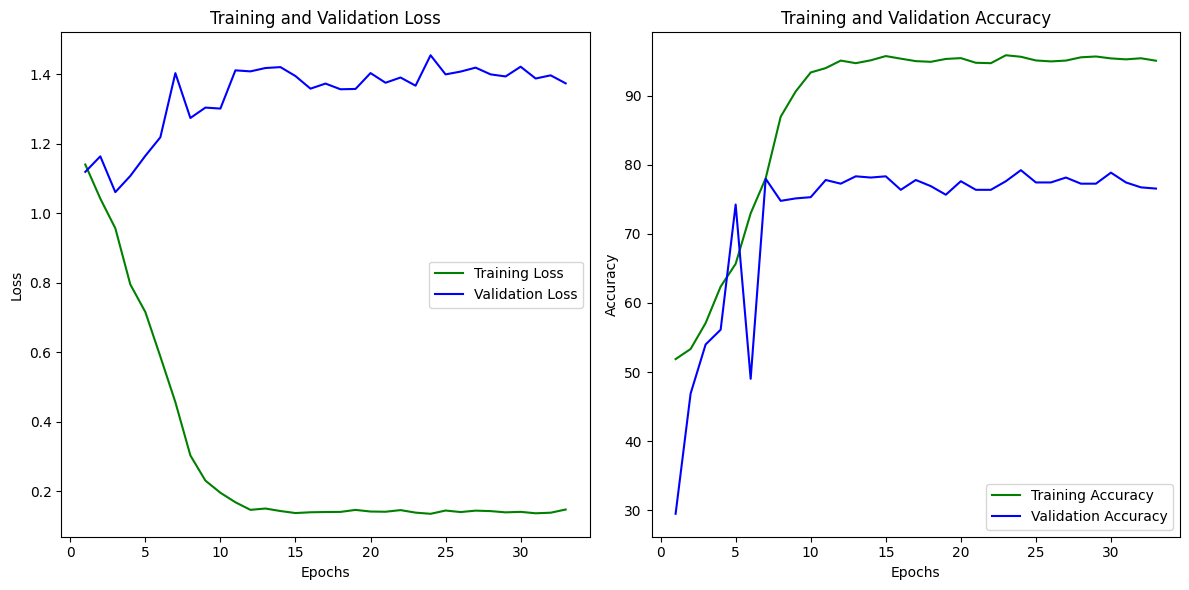

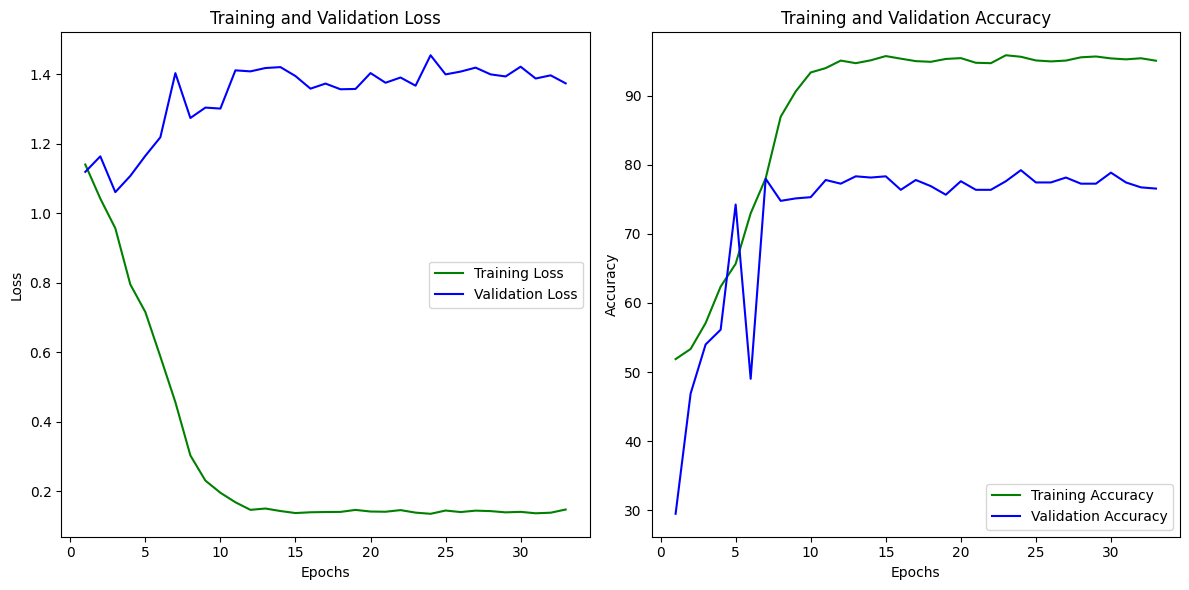


Epoch 34/50
-------------------------------
Epoch: 33, Learning Rate: 0.000000 

Epoch 34/50
-------------------------------
Epoch: 33, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)
<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.140648, correct predictions: 16, total: 16
Batch 0/317 processed, running loss: 0.140648, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 9.336999, correct predictions: 1075, total: 1136
Batch 70/317 processed, running loss: 9.336999, correct predictions: 1075, total: 1136
Batch 140/317 processed, running loss: 19.748267, correct predictions: 2139, total: 2256
Batch 140/317 processed, running loss: 19.748267, correct predictions: 2139, total: 2256
Batch 210/317 processed, running loss: 29.588845, correct predictions: 3200, total: 3376
Batch 210/317 processed, running loss: 29.588845, correct predictions: 3200, total: 3376
Batch 280/317 processed, running loss: 39.855207, correct predictions: 4254, total: 4496
Batch 280/317 processed, running loss: 39.855207, correct predictions: 4254, total: 4496

Training Loss per batch = 0.141465	Accuracy on Training set = 94.705650% [4794/5062]

Training Loss per batch = 0.141465	Accura

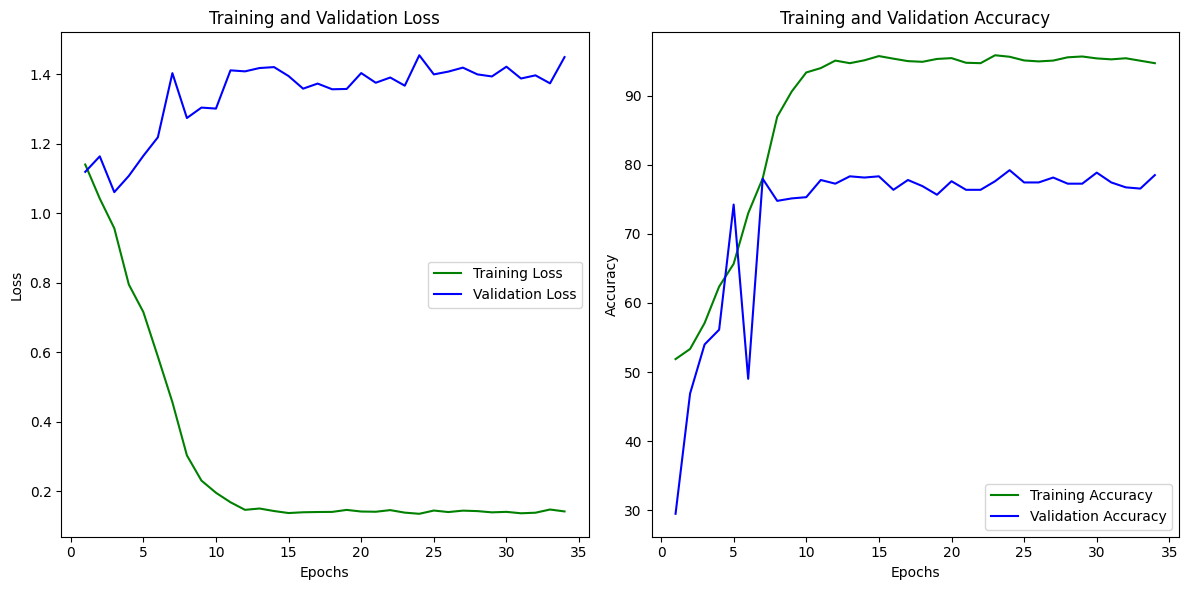

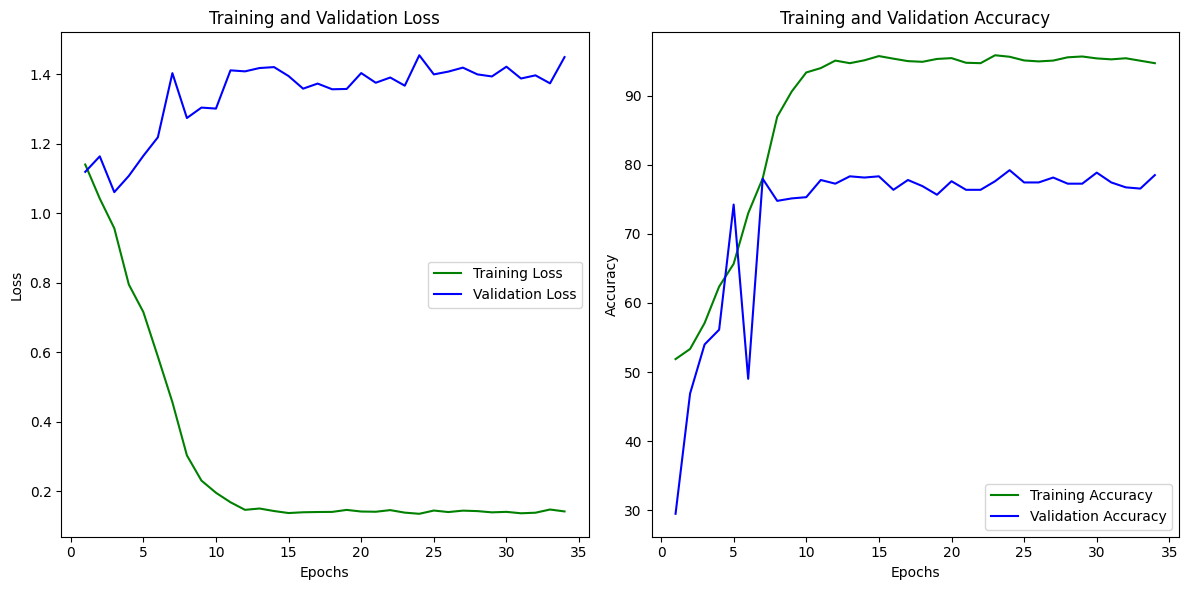


Epoch 35/50
-------------------------------
Epoch: 34, Learning Rate: 0.000000 

Epoch 35/50
-------------------------------
Epoch: 34, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)
<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.360285, correct predictions: 12, total: 16
Batch 0/317 processed, running loss: 0.360285, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 10.924179, correct predictions: 1081, total: 1136
Batch 70/317 processed, running loss: 10.924179, correct predictions: 1081, total: 1136
Batch 140/317 processed, running loss: 19.992367, correct predictions: 2149, total: 2256
Batch 140/317 processed, running loss: 19.992367, correct predictions: 2149, total: 2256
Batch 210/317 processed, running loss: 28.919525, correct predictions: 3219, total: 3376
Batch 210/317 processed, running loss: 28.919525, correct predictions: 3219, total: 3376
Batch 280/317 processed, running loss: 38.995993, correct predictions: 4263, total: 4496
Batch 280/317 processed, running loss: 38.995993, correct predictions: 4263, total: 4496

Training Loss per batch = 0.141724	Accuracy on Training set = 94.725405% [4795/5062]

Training Loss per batch = 0.141724	Accu

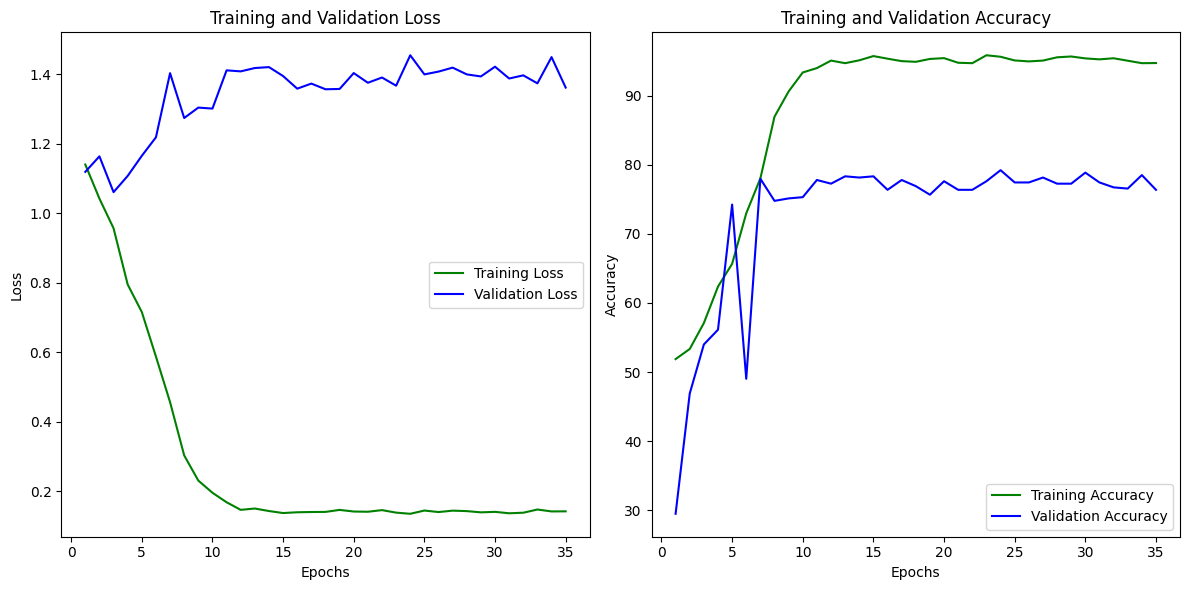

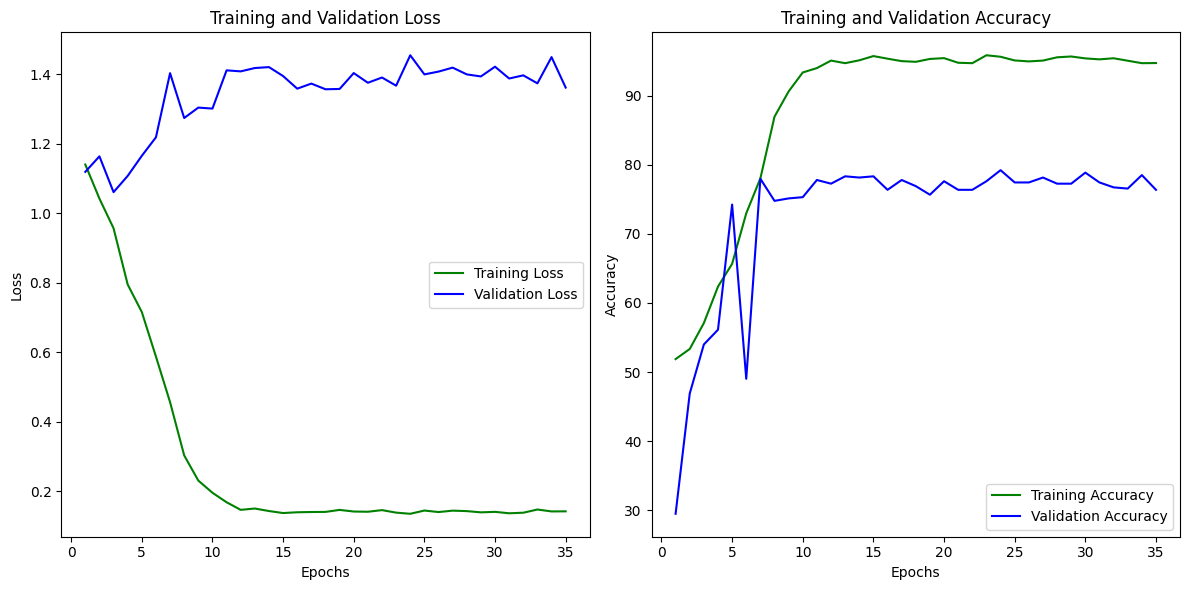


Epoch 36/50
-------------------------------
Epoch: 35, Learning Rate: 0.000000 

Epoch 36/50
-------------------------------
Epoch: 35, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)
<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.163525, correct predictions: 16, total: 16
Batch 0/317 processed, running loss: 0.163525, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 10.572795, correct predictions: 1074, total: 1136
Batch 70/317 processed, running loss: 10.572795, correct predictions: 1074, total: 1136
Batch 140/317 processed, running loss: 21.484713, correct predictions: 2135, total: 2256
Batch 140/317 processed, running loss: 21.484713, correct predictions: 2135, total: 2256
Batch 210/317 processed, running loss: 31.007552, correct predictions: 3213, total: 3376
Batch 210/317 processed, running loss: 31.007552, correct predictions: 3213, total: 3376
Batch 280/317 processed, running loss: 41.799428, correct predictions: 4268, total: 4496
Batch 280/317 processed, running loss: 41.799428, correct predictions: 4268, total: 4496

Training Loss per batch = 0.146516	Accuracy on Training set = 95.120506% [4815/5062]

Training Loss per batch = 0.146516	Accu

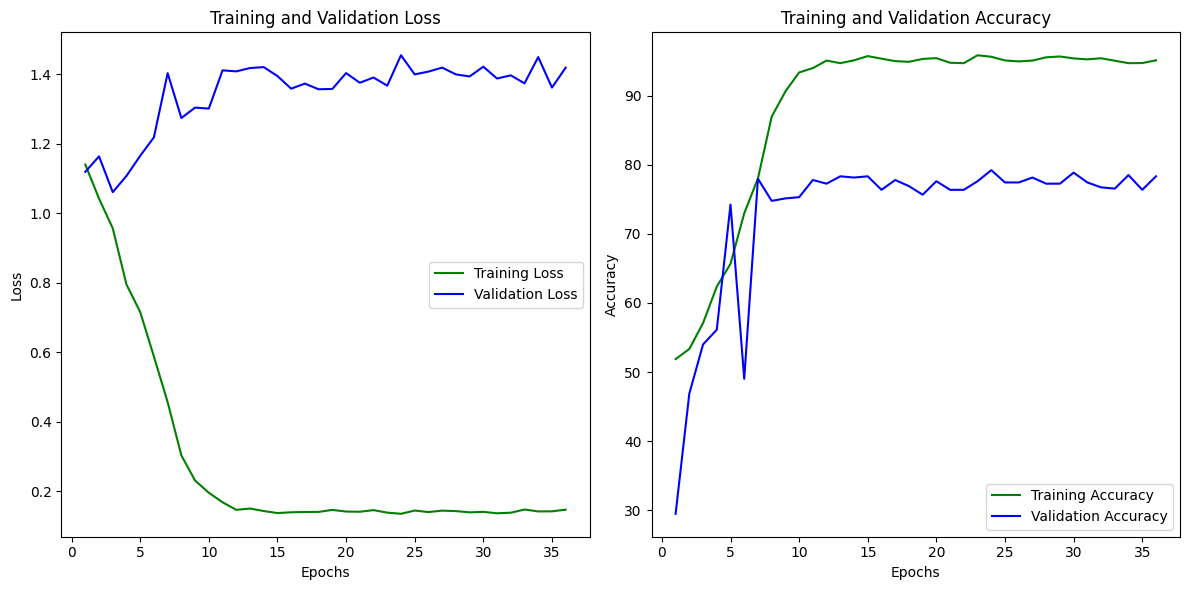

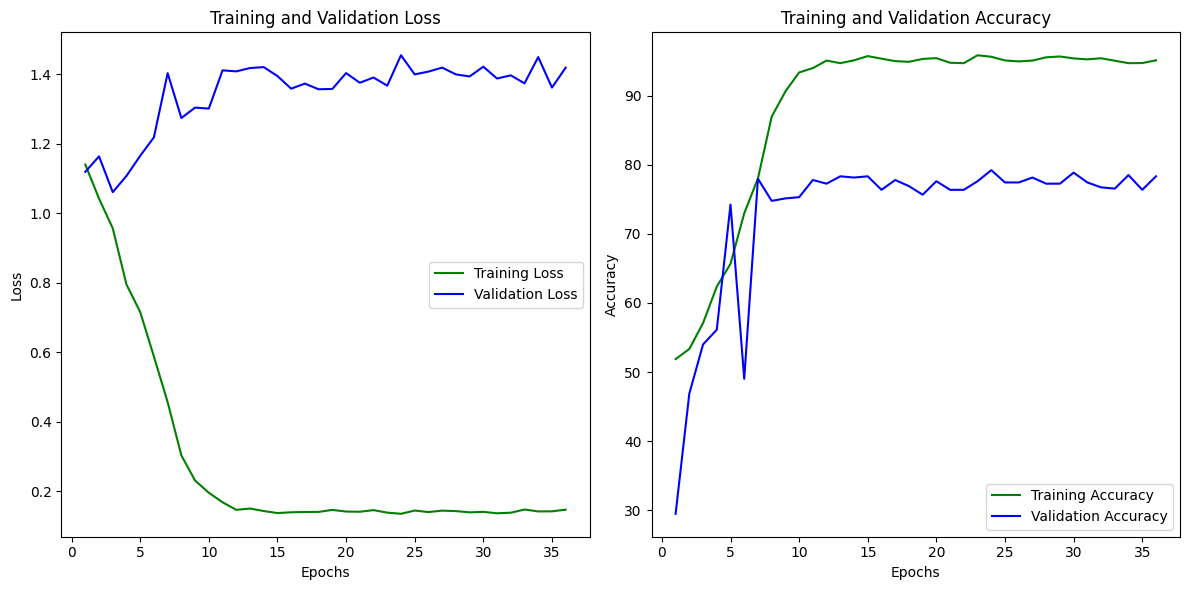


Epoch 37/50
-------------------------------
Epoch: 36, Learning Rate: 0.000000 

Epoch 37/50
-------------------------------
Epoch: 36, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)
<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.042884, correct predictions: 16, total: 16
Batch 0/317 processed, running loss: 0.042884, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 9.148242, correct predictions: 1087, total: 1136
Batch 70/317 processed, running loss: 9.148242, correct predictions: 1087, total: 1136
Batch 140/317 processed, running loss: 19.372317, correct predictions: 2158, total: 2256
Batch 140/317 processed, running loss: 19.372317, correct predictions: 2158, total: 2256
Batch 210/317 processed, running loss: 28.409767, correct predictions: 3222, total: 3376
Batch 210/317 processed, running loss: 28.409767, correct predictions: 3222, total: 3376
Batch 280/317 processed, running loss: 39.796903, correct predictions: 4288, total: 4496
Batch 280/317 processed, running loss: 39.796903, correct predictions: 4288, total: 4496

Training Loss per batch = 0.144311	Accuracy on Training set = 95.377321% [4828/5062]

Training Loss per batch = 0.144311	Accura

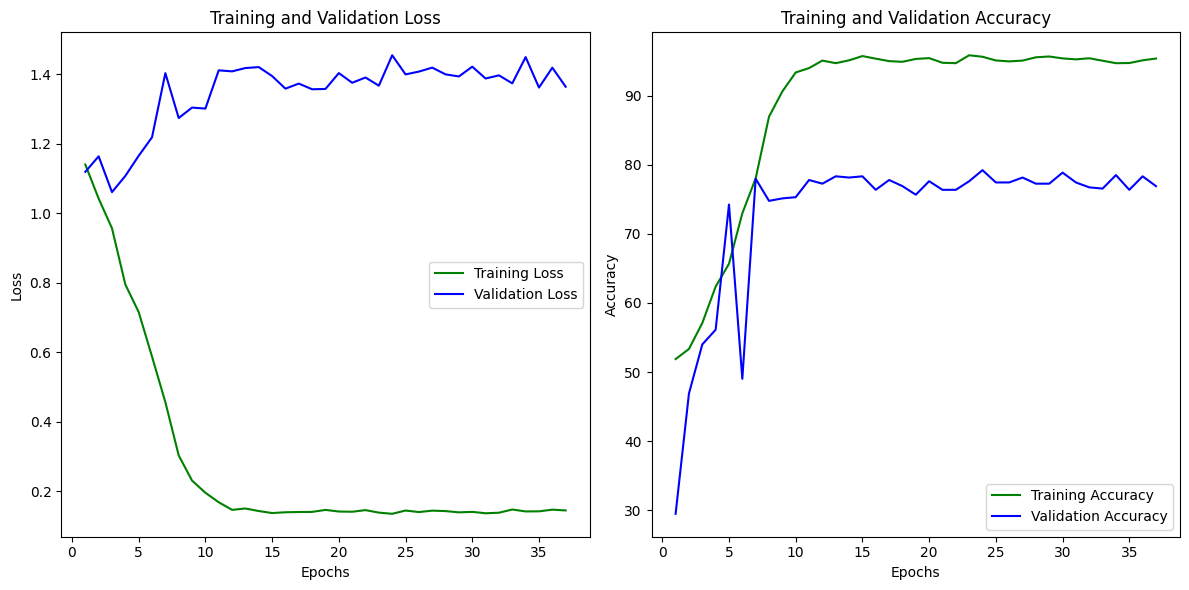

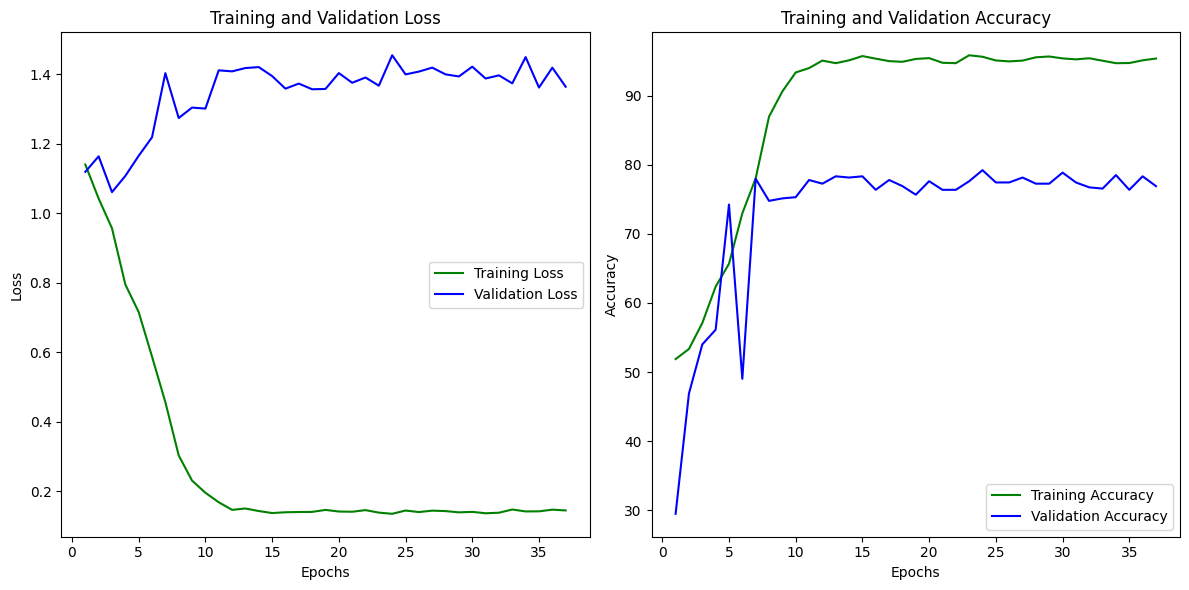


Epoch 38/50
-------------------------------
Epoch: 37, Learning Rate: 0.000000 

Epoch 38/50
-------------------------------
Epoch: 37, Learning Rate: 0.000000 


<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)
<ipython-input-15-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.364013, correct predictions: 13, total: 16
Batch 0/317 processed, running loss: 0.364013, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 9.802129, correct predictions: 1074, total: 1136
Batch 70/317 processed, running loss: 9.802129, correct predictions: 1074, total: 1136
Batch 140/317 processed, running loss: 19.326868, correct predictions: 2145, total: 2256
Batch 140/317 processed, running loss: 19.326868, correct predictions: 2145, total: 2256
Batch 210/317 processed, running loss: 29.019231, correct predictions: 3217, total: 3376
Batch 210/317 processed, running loss: 29.019231, correct predictions: 3217, total: 3376
Batch 280/317 processed, running loss: 40.627236, correct predictions: 4285, total: 4496
Batch 280/317 processed, running loss: 40.627236, correct predictions: 4285, total: 4496

Training Loss per batch = 0.146352	Accuracy on Training set = 95.199526% [4819/5062]

Training Loss per batch = 0.146352	Accura

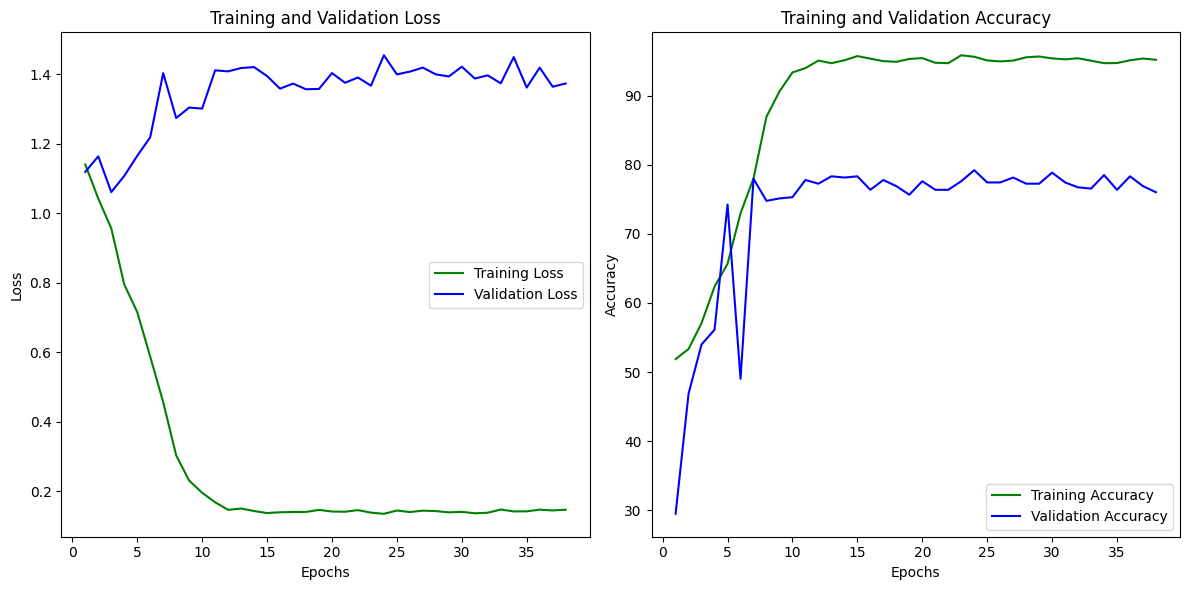

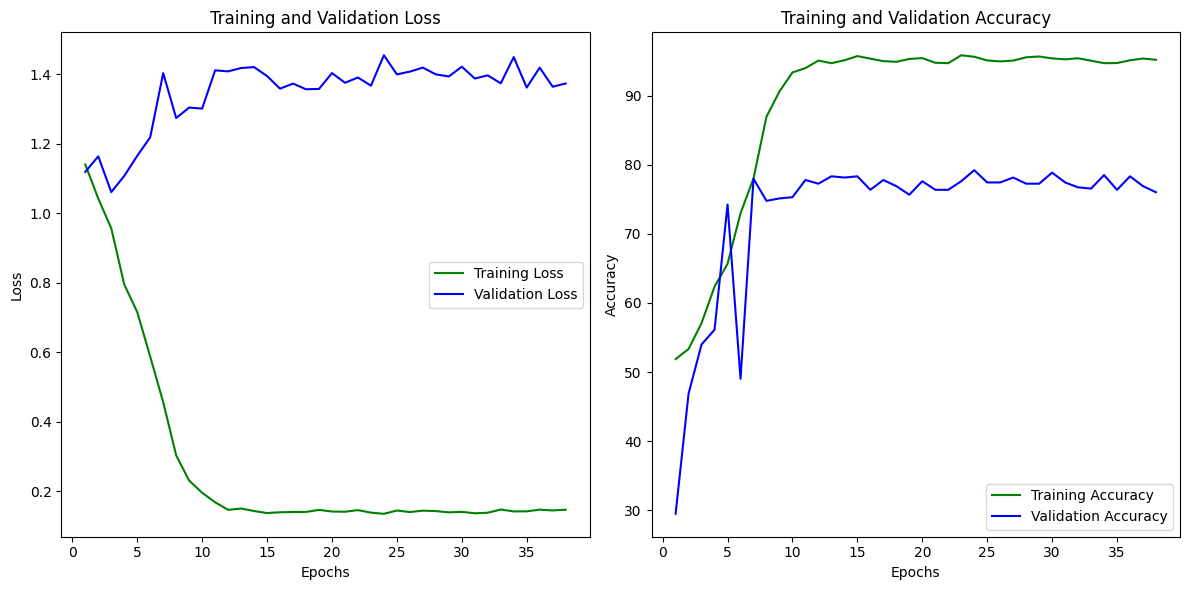

Early stopping at epoch 38, the validation loss did not improve for the last 35 epochs

Training has completed!
Early stopping at epoch 38, the validation loss did not improve for the last 35 epochs

Training has completed!


In [20]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005, weight_decay=1e-5)
nb_epochs = 50
patience = 35

#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/unzip

In [ ]:
model = torch.load("DR_ResNet50_test.pt")
model.eval()  # Set the model to evaluation mode

# Store all the model predictions for the test set
all_preds = []
all_labels = []

# No need to track gradients for evaluation, saves memory and computations
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# For multiclass case:
num_classes = cm.shape[0]  # assuming cm is a square matrix

for i in range(num_classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp  # sum across the row, excluding the diagonal element
    fp = cm[:, i].sum() - tp  # sum down the column, excluding the diagonal element
    tn = cm.sum() - fn - fp - tp

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"For class {i}, Sensitivity: {sensitivity}, Specificity: {specificity}")


In [ ]:
!nvidia-smi

In [ ]:
!pwd

In [ ]:
!zip -r data.zip test train